# Some maybe usefull stuff:
- Lets keep all the question to Antonio to trello
- The code to mark text: $**<code style="background:yellow;color:blue"> text</code>**$

In [1]:
# pip install -U imbalanced-learn

# 1. Importing dependencies and data

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
#import streamlit as st
import os
import time

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score

from sklearn.ensemble import RandomForestClassifier #proba #featimp
from imblearn.ensemble import BalancedRandomForestClassifier #proba #featimp
from sklearn.linear_model import LogisticRegression #proba #coef
from sklearn.svm import SVC #kernel #proba #coef 
from sklearn.neighbors import KNeighborsClassifier #proba
from sklearn.naive_bayes import GaussianNB #proba
from sklearn.ensemble import AdaBoostClassifier #proba #featimp
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis #proba
from sklearn.neural_network import MLPClassifier #coef #proba
import xgboost as xgb #featimp #coef #proba

In [15]:
#Getting the data

raw_data = pd.read_csv(r"C:\Users\katar\OneDrive\Dokumenty\Edukacja\Data Science\6_DS_Project\Project\03_Coding\Cards_data\creditcard.csv")

#raw_data = pd.read_csv(r"D:\06_projekt_i_data_science\coding ground\raw data\creditcard.csv")

## 1.1 Classes and functions used

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

#######################################################################################################################
#####   Class used to pre-process the raw dataset 
#######################################################################################################################

class DataCleaner(BaseEstimator, TransformerMixin):
    '''The DataCleaner class is a custom transformer that can be used to clean and preprocess data in a machine learning pipeline.

    The class has several parameters:
        - hour: a boolean parameter that indicates whether to convert the Time feature to hours and one-hot-encode the resulting hour feature (default True)
        - feature_to_drop: a list of feature names to drop from the DataFrame (default [])
        - labels: a boolean parameter that indicates whether to split the Class feature (if it exists) from the other features and store it separately (default True)
        - imputer: an imputer object from scikit-learn to use for imputing missing values in the DataFrame (default None)
        - scaler: a scaler object from scikit-learn to use for scaling the numerical features in the DataFrame (default None)

    
    The class implements two methods, fit and transform. The functions takes data argument which must be a DataFrame'''

    def __init__(self, hour:bool =True, feature_to_drop:list =[], labels:bool =True, imputer:str = None, \
                 amount_scaler:str = None, time_scaler:str = None, amount_log:bool = False):
        self.hour = hour
        self.feature_to_drop = feature_to_drop
        self.labels = labels
        self.imputer = imputer
        self.amount_scaler = amount_scaler
        self.time_scaler = time_scaler
        self.labels_data = None
        self.time = ['Time']
        self.amount = ['Amount']
        self.amount_log = amount_log
#         self.data_num = ['Amount'] # other columns have been already scaled.
        
        
    def fit(self, data, y=None):
        if self.imputer:
            self.imputer.fit(data)
        
        if self.amount_scaler:
            self.amount_scaler.fit(data.loc[:,self.amount])
            
        if self.time_scaler:
            self.time_scaler.fit(data.loc[:,self.time])
           
        
        return self 
    
    
    def transform(self, data, y=None):
        # make a copy of the input data
        data = data.copy()
        
        # Dropping all the rows where "Class" is missing
        if 'Class' in data.columns:
            data = data.dropna(axis=0, subset = 'Class')
        
       
        #Imputing missing_values 
        if data.isnull().values.any() or data.isna().values.any():
            data = pd.DataFrame(self.imputer.transform(data), columns=data.columns)
       
         # log transform amount
        if self.amount_log == True:
            data['Amount'] = np.log1p(data['Amount'])
            
       
        # Spliting labels from other features (if the data includes column 'Class'):
        if self.labels:
            if 'Class' in data.columns:
                self.labels_data = data['Class']
                data = data.drop('Class', axis=1)
                
            else:
                raise ValueError("No target variable 'Class' found in the dataset")
        labels_data = self.labels_data

        if self.amount_scaler:
            data_amount_scaled = self.amount_scaler.transform(data.loc[:,self.amount])
            data.loc[:,self.amount] = data_amount_scaled
            
        if self.time_scaler:
            data_time_scaled = self.time_scaler.transform(data.loc[:,self.time])
            data.loc[:,self.time] = data_time_scaled


        # Converting 'Time' to 'hours':
        if self.hour:
            if 'Time' in data.columns:
                data['hour'] = ((((data['Time']) // (60 * 60)) % 24) + 1)
                data['hour'] = data['hour'].astype(int)
                data = data.drop('Time', axis=1)
            
                # one-hot-encoded dataset
                data = pd.get_dummies(data, columns=['hour'], prefix='hour')
            else:
                print("No 'Time' variable in the dataset")

        # Dropping not needed features based on the feature_to_drop list
        if self.feature_to_drop:
            data = data.drop(self.feature_to_drop, axis=1)
        
        
        return data, labels_data
    
#######################################################################################################################
#####   Function to plot the ROC curve
#######################################################################################################################

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)

    
    
#######################################################################################################################
#####   Function used to test different models
#######################################################################################################################
    
def model_tester(clf, clf_name, X_train, y_train, X_val, y_val):
    print(f'============ {clf_name} ============')
    
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    try:
        feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': clf.feature_importances_})
        print(feature_importances.sort_values('importance', ascending=False, inplace=True))
    except Exception as e: 
        print(e)
        print(f'The {clf_name} model does not have a feature importance parameter')
        
    try:
        coefs = pd.DataFrame({'feature': X_train.columns, 'coef': clf.coef_})
        print(coefs.sort_values('coef', ascending=False, inplace=True))
    except Exception as e: 
        print(e)
        print(f'The {clf_name} model does not have a coef parameter')
    
    start_time = time.time()
    y_pred = clf.predict(X_val)
    test_time = time.time() - start_time
    
    # Precision and recall to include in the results
    precision_real = precision_score(y_val, y_pred)
    recall_real = recall_score(y_val, y_pred)
    
    print(metrics.classification_report(y_val, y_pred, digits=4), end='\n\n===============================================\n')
    bal_acc_score = balanced_accuracy_score(y_val, y_pred)
#     print(bal_acc_score, end='\n\n===============================================\n')
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    y_prob = clf.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    plot_roc_curve(fpr,tpr)
    plt.show()
    rocauc_score = roc_auc_score(y_val, y_prob)
    print(f'ROC AUC score: {rocauc_score}', end='\n\n===============================================\n')
    conf_mtr = confusion_matrix(y_val, y_pred)
    print(conf_mtr, end='\n\n===============================================\n')
    
    return [bal_acc_score,precision_real, recall_real, f1, conf_mtr[0,1], conf_mtr[1,0], train_time, test_time]






# 2. Sanity checking the WHOLE dataset

In [4]:
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
raw_data.shape

(284807, 31)

In [7]:
raw_data.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- The dataset has 31 features
- The dataset has 284807 observations in total
- The dataset has no missing values
- The target feature is Class
- Except for Time, Amount and Class features, all other features are unnamed, which is a result of PCA dimension reduction and also serves as a way to anonymize the data
- All the features have numeric data, except Time and Class
- Class is Nominal Categoric data
- Time could be Ordinal Categoric data

# 2.1. Class feature

In [8]:
raw_data.Class.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [9]:
raw_data.Class.value_counts(normalize=False)

0    284315
1       492
Name: Class, dtype: int64

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- The overwhelming amount of transactions 99.8%, are not fraudulent
- This higly unbalanced representation of the tagret feature makes the accuracy metric unusable. We will need to use other classification metrics such as: __Precision, Recall, F1 score, ROC AUC score__
- Why? Only by predicting all transactions as non fraud -> the accuracy will be over 0,99!

# 3. Spliting the data into training, validation and test set

In [17]:
# spliting the data into train and test set
raw_train, raw_valid_test = train_test_split(raw_data, test_size=0.4, random_state = 42, shuffle=True, stratify=raw_data["Class"])
# spliting the test set into validation and test set
raw_val, raw_test = train_test_split(raw_valid_test, test_size=0.5, random_state = 42, shuffle=True, stratify=raw_valid_test["Class"])

In [11]:
print("Training set dimensions: ", raw_train.shape)#, 'amd training lagels:', y_train.shape,)
print("Test set dimensions: ", raw_test.shape)#, 'and test labels:', y_test.shape)
print("Validation dataset dimensions: ", raw_val.shape)#, 'and validation labels:', y_val.shape)

Training set dimensions:  (170884, 31)
Test set dimensions:  (56962, 31)
Validation dataset dimensions:  (56961, 31)


# --------------- 4. EDA -----------------------

In [12]:
raw_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
109011,71174.0,-2.108259,1.173406,1.614294,0.482867,0.067209,-0.191013,0.191246,-1.705859,-0.177615,...,1.520624,-0.388595,0.260114,0.340667,0.400474,-0.413089,-0.348291,0.215298,19.99,0
280683,169683.0,2.313997,-1.311064,-1.421228,-1.724356,-1.003480,-0.912621,-0.898765,-0.221952,-1.658076,...,0.089446,0.664605,0.029245,-0.347503,0.069152,0.074159,-0.024483,-0.076422,15.00,0
158318,111127.0,2.104946,0.155284,-1.402870,0.311489,0.504248,-0.690870,0.138943,-0.417801,1.894584,...,0.107745,0.759527,-0.022144,0.465282,0.402861,-0.478955,-0.016524,-0.053868,1.00,0
243733,152052.0,2.072408,-0.015687,-1.310880,0.373435,-0.063476,-1.380722,0.243699,-0.394350,0.631048,...,0.243262,0.858393,0.003403,0.077370,0.259102,-0.110464,-0.021166,-0.058972,1.99,0
177016,123008.0,2.046409,0.156335,-2.006987,0.384525,0.604029,-0.756561,0.232367,-0.230789,0.072474,...,0.326565,1.165945,-0.109465,0.793698,0.377195,0.837559,-0.075171,-0.053246,1.57,0


In [13]:
raw_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### 4.1. Checking for alternate missing values → values that are 0

In [14]:
# Checking if there is any zero values in the training dataset (there is no Nan, but maybe they had 0 as missing value...)
# Excluding Class in this check as >99% of the data has Class = 0
raw_train[raw_train.iloc[:,0:30] == 0].dropna(how='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
215250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
143435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
199399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
65356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
79512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
256028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
176142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
161304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [15]:
# All the amounts are zero or positive
print(f'Is any amount 0? --> {any(raw_train.Amount== 0)}')
print(f'Are all amounts bigger than or equal to 0? --> {all(raw_train.Amount>= 0)}')

Is any amount 0? --> True
Are all amounts bigger than or equal to 0? --> True


### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- There seems to be no missing values in the dataset
- There are 1070 observations where Amount = 0
- There are 2 observations where Time = 0 (we know this from Chapter 2. Sanity checking the WHOLE dataset, but these observations are not present in the training set)
- We assume that the transactions where Amount = 0 are valid tranactions. These could be transactions where a person needs to "pay a deposit" in order to register to a page, but real money is drawn after the trial period is over.
- There are no transactions with a negative Amount

### 4.2. Analysis of numeric data

In [16]:
raw_train.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000,...,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000,170884.00000
mean,94939.37288,0.00197,-0.00445,-0.00249,0.00011,0.00041,-0.00079,-0.00178,-0.00014,0.00331,...,0.00140,0.00034,0.00064,0.00026,-0.00090,0.00025,-0.00050,0.00012,88.42941,0.00173
std,47506.71221,1.95921,1.65161,1.51925,1.41495,1.38177,1.33247,1.24667,1.19175,1.09781,...,0.73926,0.72656,0.62725,0.60509,0.52206,0.48256,0.40685,0.31471,255.43632,0.04151
min,0.00000,-46.85505,-63.34470,-48.32559,-5.68317,-113.74331,-21.92931,-43.55724,-73.21672,-13.43407,...,-34.83038,-10.93314,-44.80774,-2.83663,-10.29540,-2.60455,-22.56568,-15.43008,0.00000,0.00000
25%,54277.75000,-0.91788,-0.60133,-0.89262,-0.84617,-0.69185,-0.76804,-0.55509,-0.20791,-0.63949,...,-0.22780,-0.54198,-0.16219,-0.35470,-0.31706,-0.32719,-0.07069,-0.05296,5.74000,0.00000
50%,84907.50000,0.02251,0.06266,0.17883,-0.02059,-0.05647,-0.27367,0.03973,0.02256,-0.04798,...,-0.02868,0.00674,-0.01065,0.04137,0.01640,-0.05211,0.00122,0.01116,22.05000,0.00000
75%,139422.25000,1.31587,0.80114,1.02332,0.74360,0.61078,0.39721,0.57156,0.32606,0.60140,...,0.18644,0.52834,0.14776,0.43952,0.34958,0.24210,0.09084,0.07782,77.50000,0.00000
max,172792.00000,2.45189,22.05773,9.38256,16.87534,32.91146,73.30163,120.58949,20.00721,15.59499,...,27.20284,10.50309,22.08354,4.58455,6.07085,3.51735,31.61220,15.87047,25691.16000,1.00000


### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- Time: time is represented in seconds. 0 is when the observations started, and 172792 is the second count for the last observation. This equals roughly a 48 day period.
- Amount: the smallest transfer amount was 0 (possible explanation in previous observation), and the biggest transaction amount was 25691. The average transaction amount is ~88.5, but we can see that 50% of the transactions were under 22.05, which means that the distribution of the Amount is strongly skewed and has a right tail.
- Class: we can see that only 0.173% of the transactions were fraud.
- As we don't have names for the majority of the features, it is unlikely that we can get out meaningful observations 

### 4.2.1. Distribution of the feature values

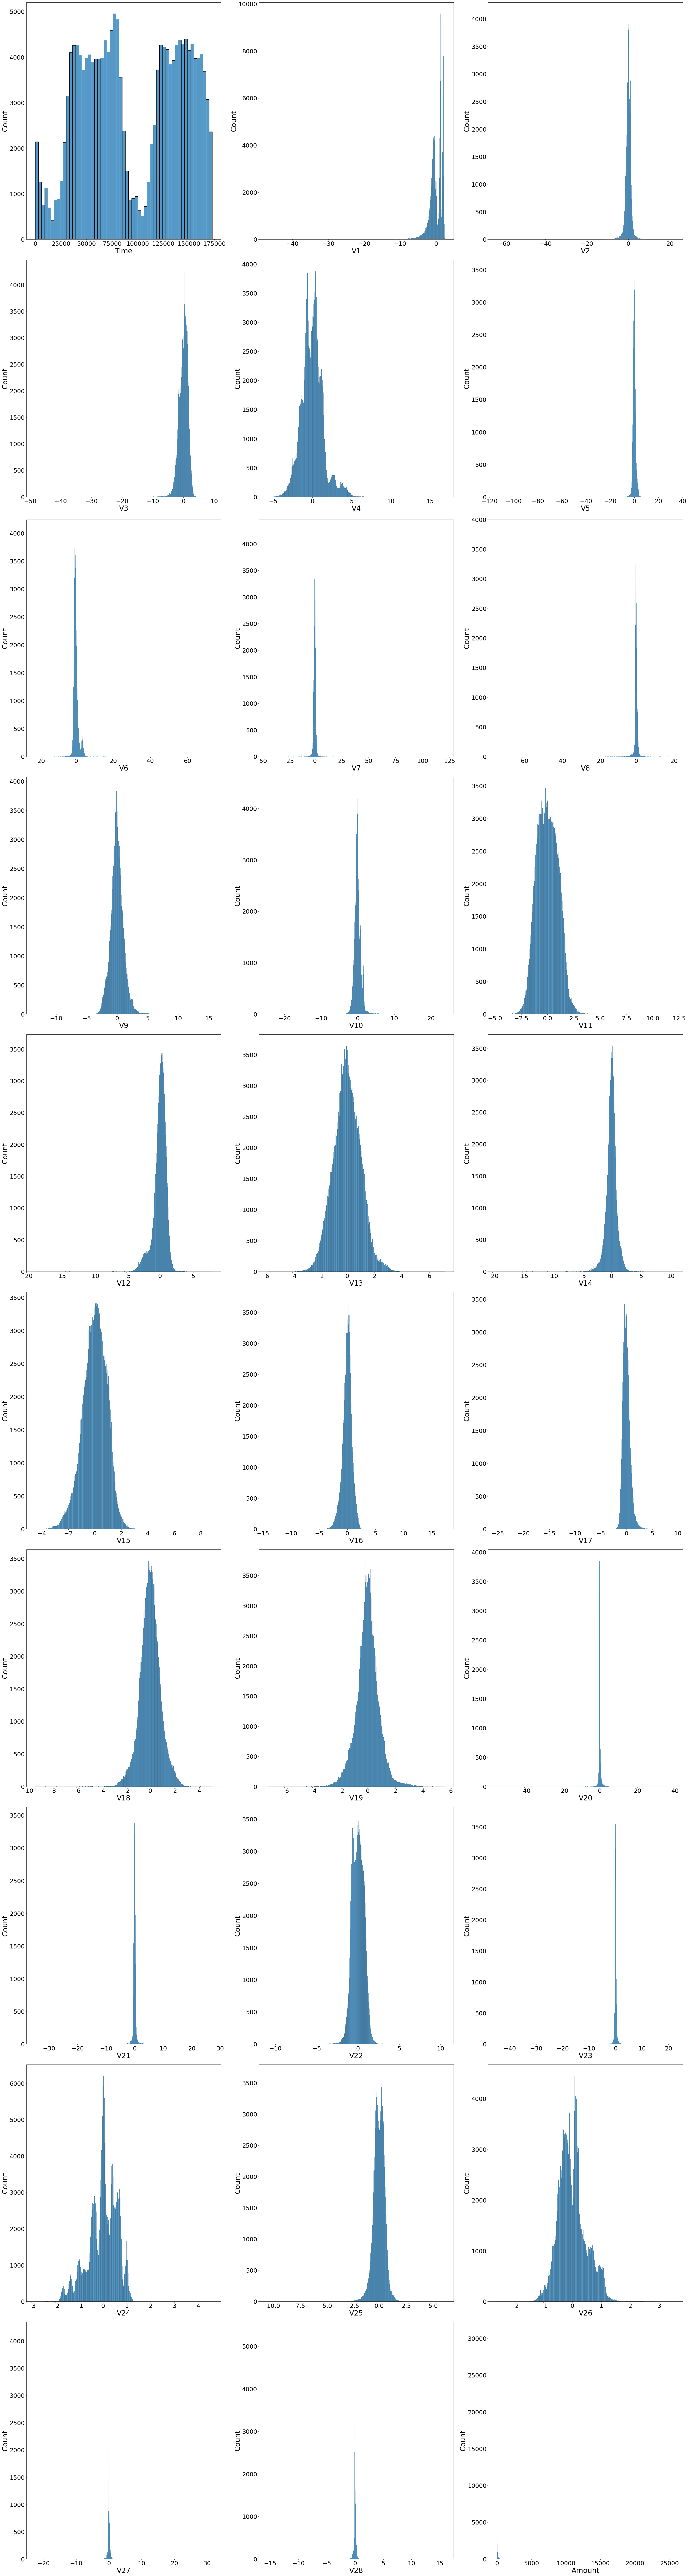

In [17]:
fig, axes = plt.subplots(len(raw_train.columns)//3, 3, figsize=(40,150), layout='constrained')
axes = axes.ravel()

for k, ax in enumerate(axes):
    p = sns.histplot(data=raw_train, x=raw_train.columns[k], ax=ax)
#     p.axes.set_title(raw_train.columns[k],fontsize=50)
    p.set_xlabel(raw_train.columns[k],fontsize=30)
    p.set_ylabel("Count",fontsize=30)
    p.tick_params(labelsize=25)
    p

### **<code style="background:lightgreen;color:black"> Observations:</code>** 

- The features (except Time, Amount and Class) seem to be standardised, as their location is around 0.
- Most of the featres distribution vaguely resemble normal distribution, but with very high curtos

### 4.3.2. Distribution of Amount

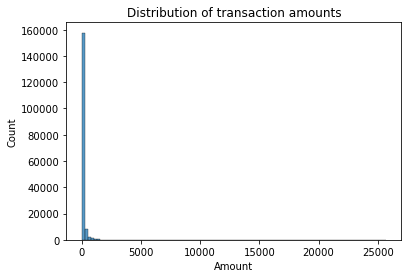

In [18]:
sns.histplot(data=raw_train, x='Amount', bins=100)
plt.title('Distribution of transaction amounts')
plt.show()

### **<code style="background:lightgreen;color:black"> Observations:</code>** 

- We can see that the $Amount$ variable is strongly skewed to the right. 

## $Amount$ as $log$

In [19]:
raw_train_log = raw_train.copy()
raw_train_log['Amount_log'] = np.log1p(raw_train_log['Amount'])

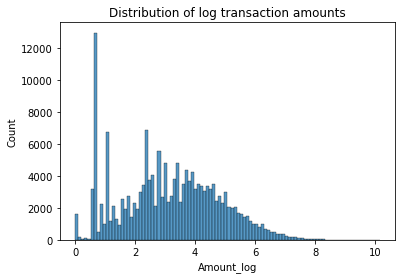

In [20]:
sns.histplot(data=raw_train_log, x='Amount_log', bins=100)
plt.title('Distribution of log transaction amounts')
plt.show()

### **<code style="background:lightgreen;color:black"> Observations:</code>** 

- It can be worth checking how models deal with logaritmicaly transformed $Amount$. 

# ↓↓↓↓↓↓↓↓↓ THIS MIGHT NOT BE NEEDED ↓↓↓↓↓↓↓↓↓ 

But the fraud Class values mean and distribution is much more visible than in the histograms

In [21]:
raw_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

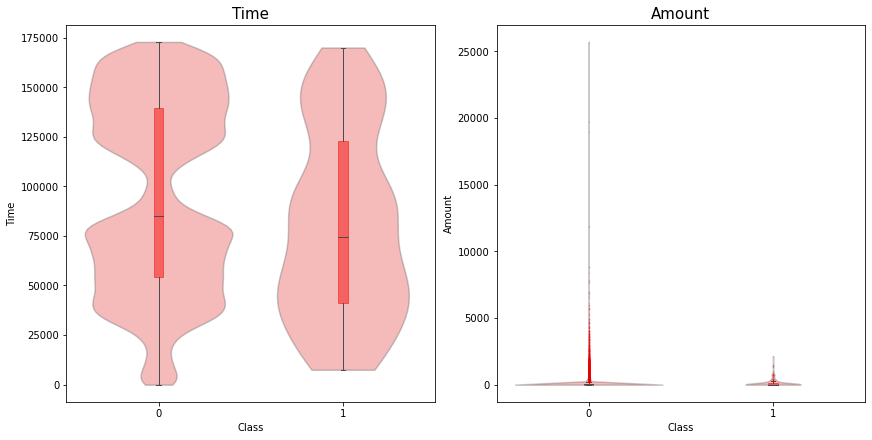

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), layout='constrained')
axes = axes.ravel()
cols = [0, -2]

for k, ax in enumerate(axes):
    p = sns.violinplot(data=raw_train, y=raw_train.columns[cols[k]], x='Class', ax=ax, color='red', cut=0, inner=None)
    boxprops = dict(color='r', alpha=0.5)
    flierprops = dict(marker='o', markeredgecolor='r', markersize=0.5, alpha=0.2)
    sns.boxplot(data = raw_train, y=raw_train.columns[cols[k]], x='Class', ax=ax, color='red', width=0.05, fliersize=0.5, linewidth=1, whis=1.5, boxprops=boxprops, flierprops=flierprops)

    p.axes.set_title(raw_train.columns[cols[k]],fontsize=15)
    p.tick_params(labelsize=10)
    plt.setp(ax.collections, alpha=.3)
    p

In [23]:
# Ratio of transactions under 100
len(raw_train[raw_train.Amount<100])/len(raw_train)

0.7978336181269166

In [24]:
# Maximum fraud amount
raw_train[raw_train.Class==1]['Amount'].max()

2125.87

# 4.4 Outliers

In [25]:
def detect_outliers(data):
    outlier_info = {}
    for column in data.columns:
        if data[column].dtype != object:
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            
            outliers = data[(data[column] > upper_bound) | (data[column] < lower_bound)][column]
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_info[column] = {"Outlier_percentage": outlier_percentage, "Total_count_of_outliers": len(outliers)}
                         
            outlier_dataframe = pd.DataFrame(outlier_info).T
                                                
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage', ascending = False)

detect_outliers(raw_train)

,Outlier_percentage,Total_count_of_outliers
V27,13.792982,23570.0
Amount,11.170736,19089.0
V28,10.767538,18400.0
V20,9.829475,16797.0
V8,8.406287,14365.0
V6,8.042883,13744.0
V23,6.509679,11124.0
V12,5.348658,9140.0
V21,5.077128,8676.0
V14,5.006320,8555.0


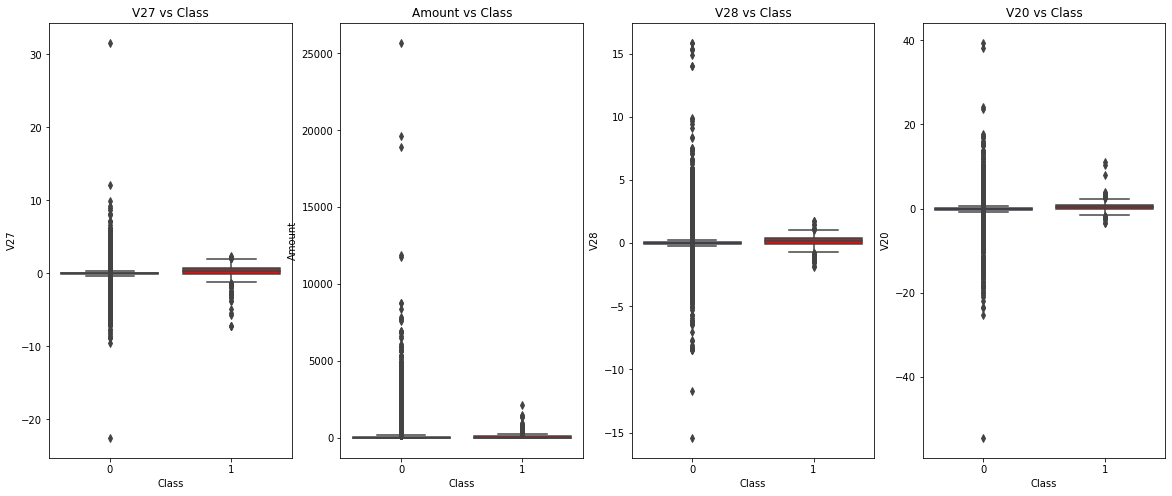

In [26]:
f, axes = plt.subplots(ncols=4, figsize=(20,8))
colors = ["#0101DF", "#DF0101"]

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V27", data=raw_train, palette=colors, ax=axes[0])
axes[0].set_title('V27 vs Class')

sns.boxplot(x="Class", y="Amount", data=raw_train, palette=colors, ax=axes[1])
axes[1].set_title('Amount vs Class')


sns.boxplot(x="Class", y="V28", data=raw_train, palette=colors, ax=axes[2])
axes[2].set_title('V28 vs Class')


sns.boxplot(x="Class", y="V20", data=raw_train, palette=colors, ax=axes[3])
axes[3].set_title('V20 vs Class')

plt.show()

## 4.4.1 Scenario: remove 10% of outliers

In [27]:
def detect_outliers_limit(data, limit, cols):
    outlier_percents = {}
    rows_to_remove = []
    for column in cols:
        if data[column].dtype != object:
            # quantiles
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            # inter quantile range
            iqr = q3 - q1

            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            # all the outliers
            outliers = data[(data[column] > upper_bound) | (data[column] < lower_bound)][column]
            # select top limit%
            abs_sorted_outliers = abs(outliers).sort_values()
            threshold = abs_sorted_outliers.quantile(1-limit)
            top_percent = abs_sorted_outliers[abs_sorted_outliers >= threshold]
            top_percent_index = top_percent.index
            [rows_to_remove.append(n) for n in top_percent_index]
            
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])

    return outlier_dataframe.sort_values(by = 'Outlier_percentage', ascending = False), set(rows_to_remove)


indexes_to_remove = detect_outliers_limit(raw_train, 0.1, ['V17', 'V14', 'V12', 'V10'])[1]
#detect_outliers_limit(raw_train, 0.1, raw_train.columns)[0]

In [28]:
# indexes_to_remove
print(f'raw_train original length: {len(raw_train)}')
print(f'indexes_to_remove original length: {len(indexes_to_remove)}')
print(f'difference of original-remove: {len(raw_train)-len(indexes_to_remove)}')
print(f'length of dataset after removal: {len(raw_train.drop(index=indexes_to_remove))}')
raw_train_minus_outliers = raw_train.drop(index=indexes_to_remove)
print(f'length of dataset with removed outliers: {len(raw_train_minus_outliers)}')

raw_train original length: 170884
indexes_to_remove original length: 1990
difference of original-remove: 168894
length of dataset after removal: 168894
length of dataset with removed outliers: 168894


In [29]:
raw_train_minus_outliers.Class.value_counts(normalize=False)

0    168851
1        43
Name: Class, dtype: int64

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- Almost 80% of all transactions are under 100
- The maximum fraud amount is 2125.87
- 11.71% of the Amount are outliers
- The features (except Time, Amount and Class) seem to be standardised, as their location is around 0.
- Most of the featres distribution vaguely resemble normal distribution, but with very high curtosis



# 4.5. Spearman correlation between features

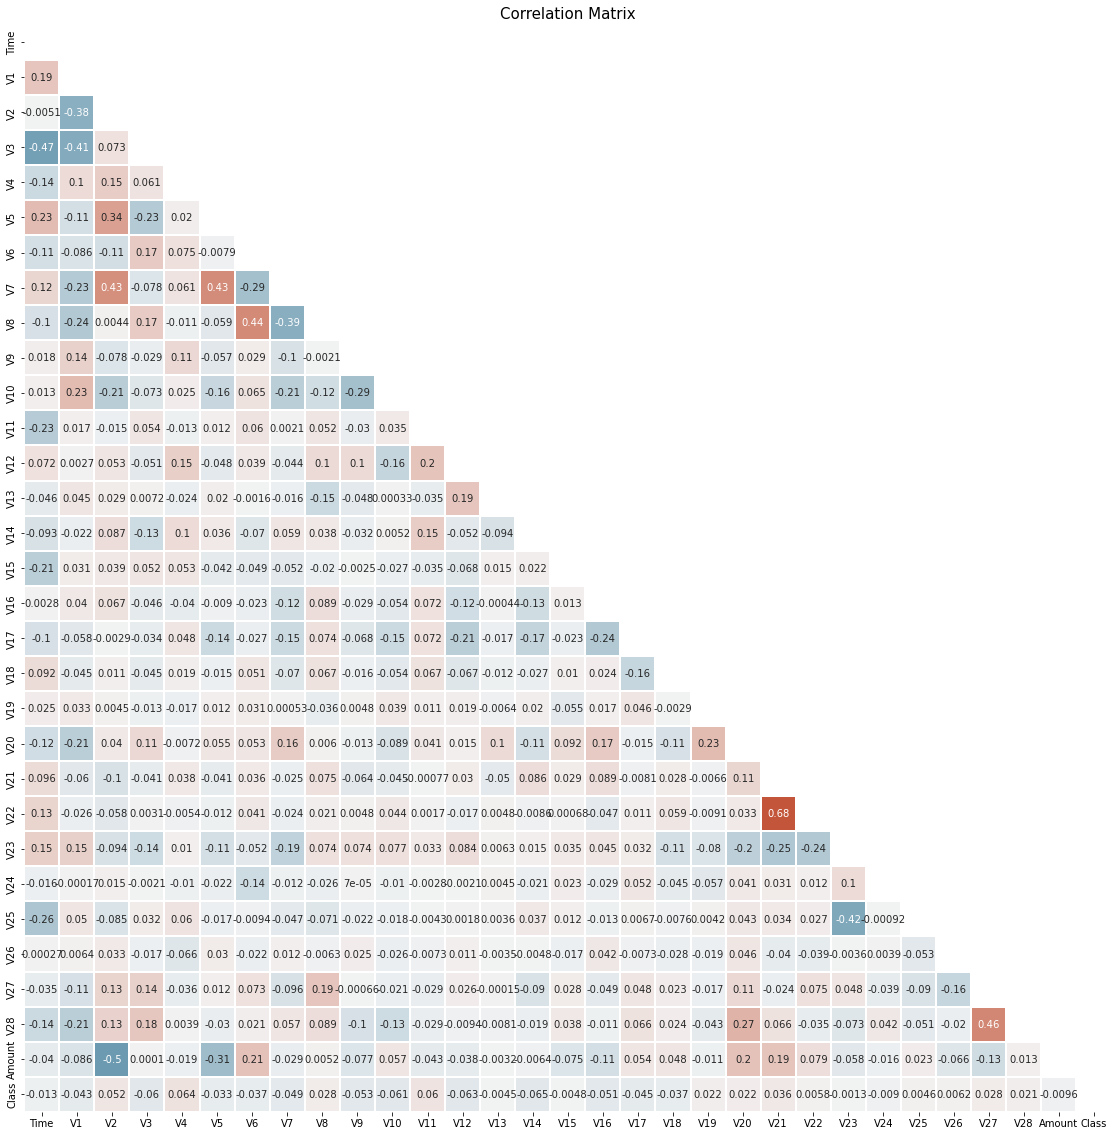

In [30]:
features = [
    'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
    'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
    'Class'
]

correlation_matrix = raw_train[features].corr(method="spearman") # pearson / spearman

#from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Correlation Matrix", fontsize=15)

Note:
The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those two variables; while Pearson's correlation assesses linear relationships, Spearman's correlation assesses monotonic relationships (whether linear or not). If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

### Highlighting the correlations below -0.1 and above 0.1

<AxesSubplot:>

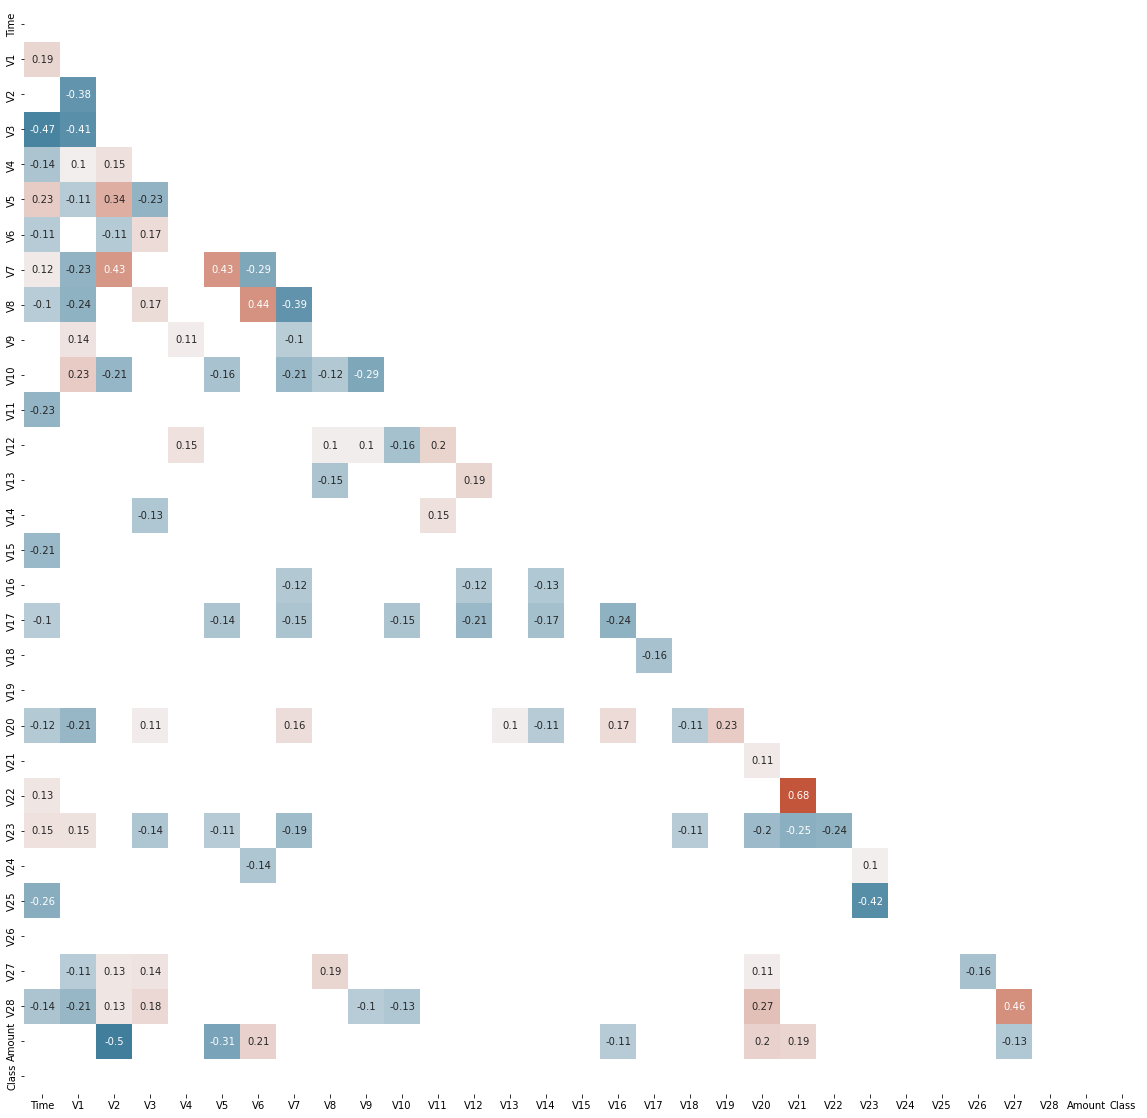

In [31]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    correlation_matrix[(correlation_matrix<-0.1)|(correlation_matrix>0.1)], 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool, )), 
    annot=True,
    cbar=False,
    cmap=sns.diverging_palette(230, 20, as_cmap=True)
)

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- 

# 4.5.1 Balanced dataset analysis

## RandomOverSampler

The most naive strategy. $RandomOverSampler()$ generates new samples by randomly sampling with replacement the current available samples.

(If repeating samples is an issue, the parameter shrinkage allows to create a smoothed bootstrap. However, the original data needs to be numerical.) 

In [32]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)


# WE need to split labels form the rest of the features before we can continue with the sampler
clean_data = DataCleaner(hour=False, labels=True)
X_train_raw, y_train_raw = clean_data.fit_transform(raw_train)

# Now we can fit the sampler
X_ros_train, y_ros_train = ros.fit_resample(X_train_raw, y_train_raw)
from collections import Counter
print(sorted(Counter(y_ros_train).items()))

[(0, 170589), (1, 170589)]


In [33]:
X_ros_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [34]:
labels = pd.DataFrame({'Class': y_ros_train})

ros_train = pd.concat([X_ros_train, labels], axis=1)
ros_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,71174.0,-2.108259,1.173406,1.614294,0.482867,0.067209,-0.191013,0.191246,-1.705859,-0.177615,...,1.520624,-0.388595,0.260114,0.340667,0.400474,-0.413089,-0.348291,0.215298,19.99,0
1,169683.0,2.313997,-1.311064,-1.421228,-1.724356,-1.003480,-0.912621,-0.898765,-0.221952,-1.658076,...,0.089446,0.664605,0.029245,-0.347503,0.069152,0.074159,-0.024483,-0.076422,15.00,0
2,111127.0,2.104946,0.155284,-1.402870,0.311489,0.504248,-0.690870,0.138943,-0.417801,1.894584,...,0.107745,0.759527,-0.022144,0.465282,0.402861,-0.478955,-0.016524,-0.053868,1.00,0
3,152052.0,2.072408,-0.015687,-1.310880,0.373435,-0.063476,-1.380722,0.243699,-0.394350,0.631048,...,0.243262,0.858393,0.003403,0.077370,0.259102,-0.110464,-0.021166,-0.058972,1.99,0
4,123008.0,2.046409,0.156335,-2.006987,0.384525,0.604029,-0.756561,0.232367,-0.230789,0.072474,...,0.326565,1.165945,-0.109465,0.793698,0.377195,0.837559,-0.075171,-0.053246,1.57,0


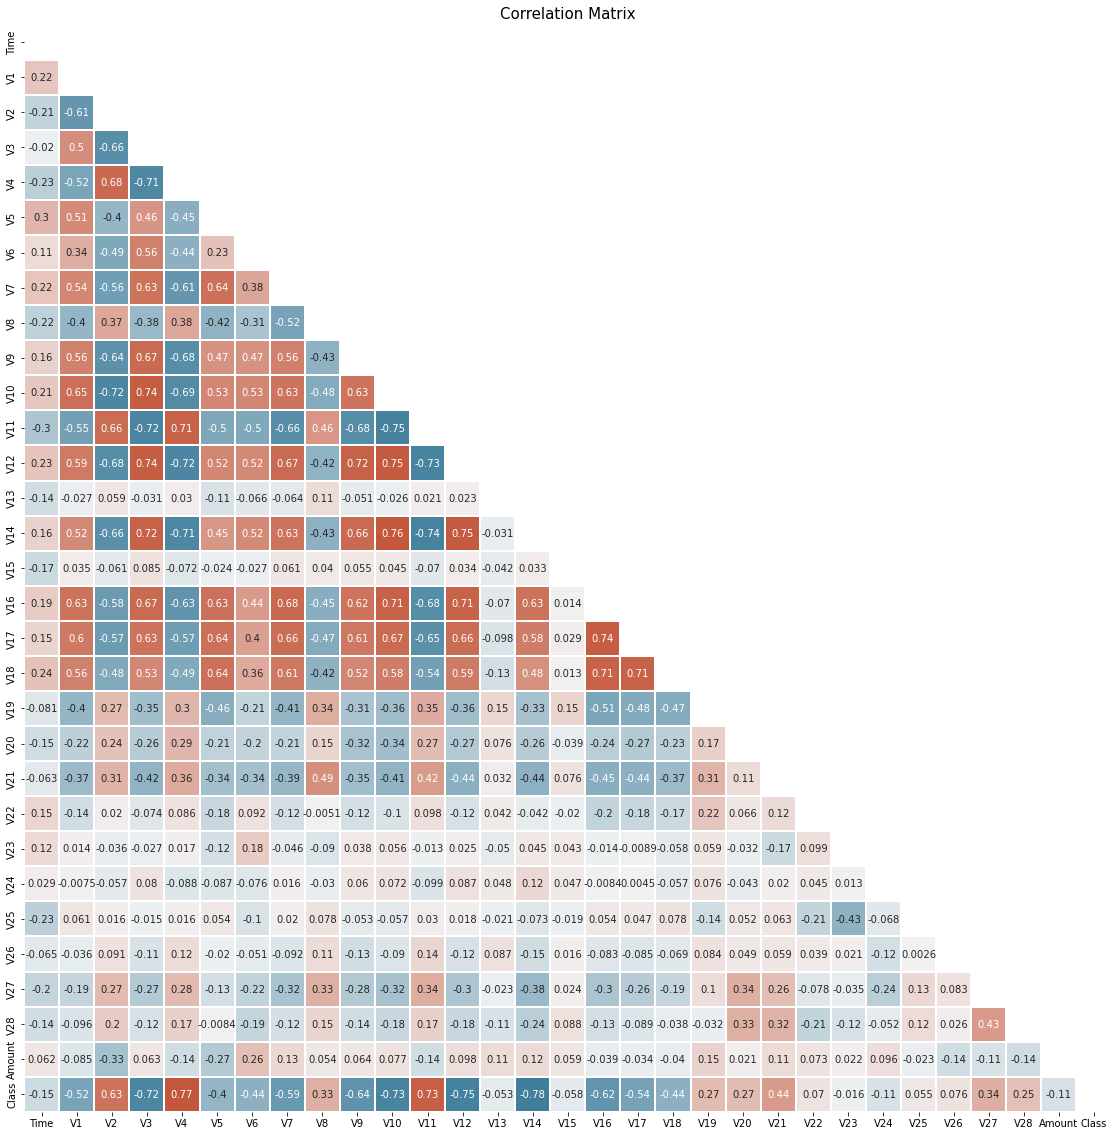

In [35]:
features = [
    'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
    'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
    'Class'
]

correlation_matrix = ros_train[features].corr(method="spearman") # pearson / spearman

#from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Correlation Matrix", fontsize=15)

In [36]:
raw_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [37]:
correlations = ros_train.corr(method='spearman')['Class']
sorted_correlations = correlations.sort_values(ascending=False)

print(sorted_correlations)

Class     1.000000
V4        0.772766
V11       0.725224
V2        0.630801
V21       0.437270
V27       0.341658
V8        0.333951
V19       0.270010
V20       0.269936
V28       0.253638
V26       0.075920
V22       0.069887
V25       0.055229
V23      -0.016392
V13      -0.052780
V15      -0.057594
V24      -0.108230
Amount   -0.114636
Time     -0.153987
V5       -0.400562
V6       -0.440513
V18      -0.440963
V1       -0.522025
V17      -0.538106
V7       -0.591674
V16      -0.618265
V9       -0.635810
V3       -0.716880
V10      -0.734480
V12      -0.754112
V14      -0.781630
Name: Class, dtype: float64


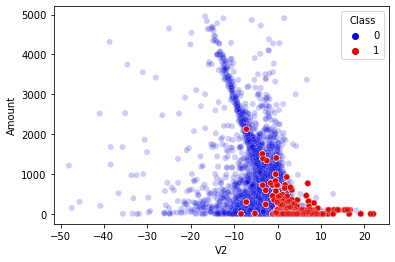

In [38]:
# To show the results of the sampler the plot showes transactions with value below 5 000 
ros_train_small = ros_train[ros_train['Amount'] <= 5000]
sns.scatterplot(x=ros_train_small['V2'], y=ros_train_small['Amount'], hue=ros_train_small['Class'], palette=colors, alpha = 0.2)

# show the plot
plt.show()

## Observations:
- after balancing training dataset with RandomOverSampler() we've got much stronger correlations between 'Class' and other features,
- on the scatterplot we can see that RandomOverSamler() copied instances of fraud transactions. 

## SMOTE

OBS: I go with standard one (all variables are presented as numbers). In case we decide that $Time$ variable is categorical we should choose $SMOTENC$.

In [39]:
from imblearn.over_sampling import SMOTE
X_smote_train, y_smote_train = SMOTE().fit_resample(X_train_raw, y_train_raw)
print(sorted(Counter(y_smote_train).items()))

[(0, 170589), (1, 170589)]


In [40]:
labels = pd.DataFrame({'Class': y_smote_train})

smote_train = pd.concat([X_smote_train, labels], axis=1)
smote_train.shape

(341178, 31)

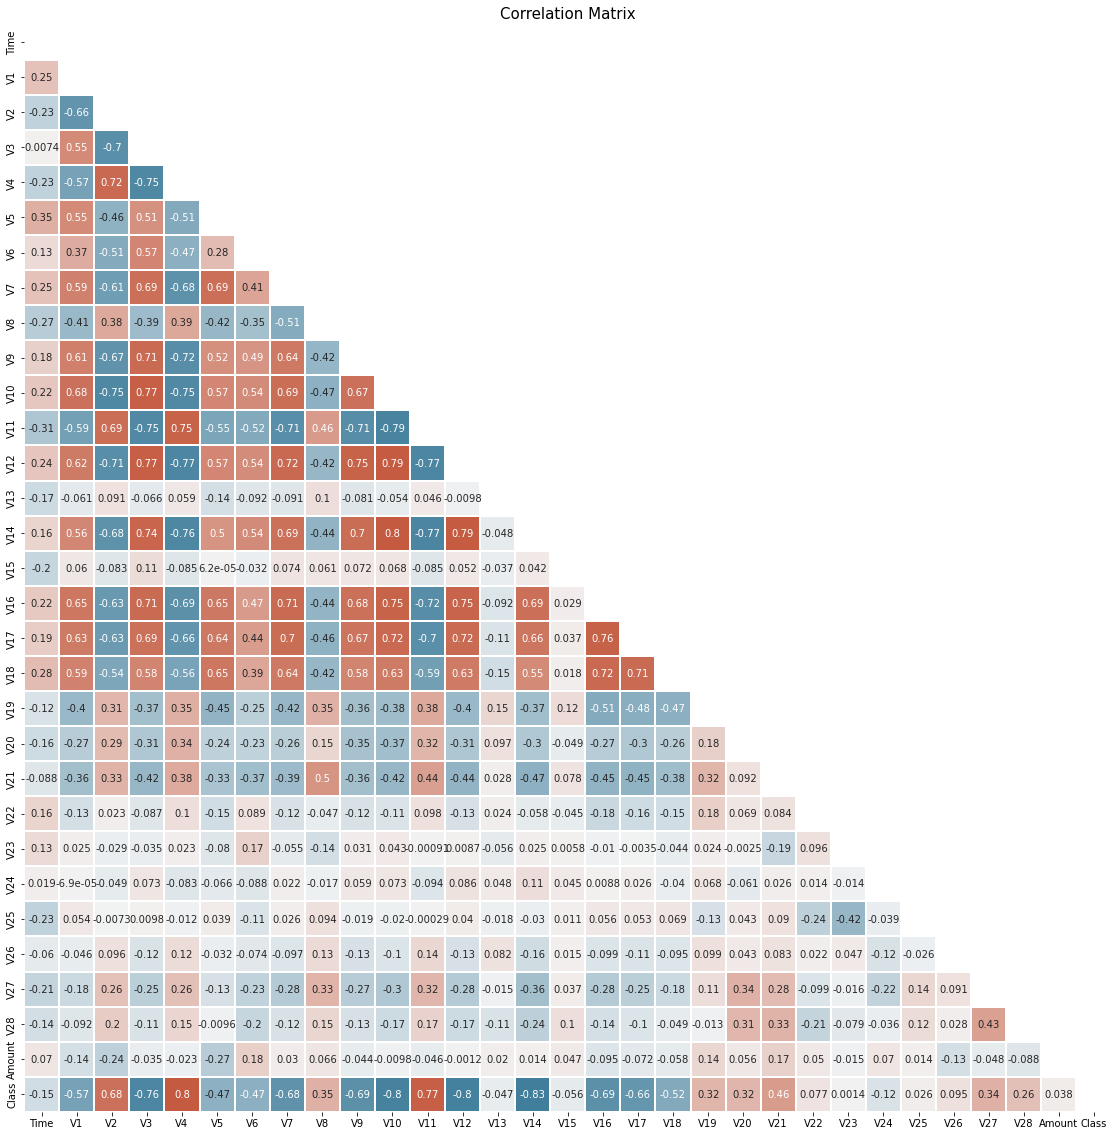

In [41]:
correlation_matrix = smote_train[features].corr(method="spearman") # pearson / spearman

#from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Correlation Matrix", fontsize=15)

In [42]:
correlations = smote_train.corr(method='spearman')['Class']
sorted_correlations = correlations.sort_values(ascending=False)

print(sorted_correlations)

Class     1.000000
V4        0.801351
V11       0.770982
V2        0.678397
V21       0.456155
V8        0.345607
V27       0.342064
V19       0.318464
V20       0.315372
V28       0.260340
V26       0.095147
V22       0.076907
Amount    0.037866
V25       0.026498
V23       0.001373
V13      -0.046803
V15      -0.056281
V24      -0.116331
Time     -0.149551
V5       -0.465245
V6       -0.473672
V18      -0.515744
V1       -0.573731
V17      -0.655824
V7       -0.675581
V16      -0.693469
V9       -0.693883
V3       -0.763225
V10      -0.800580
V12      -0.804531
V14      -0.832736
Name: Class, dtype: float64


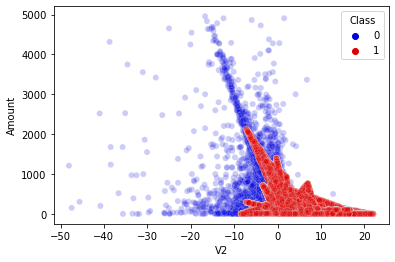

In [43]:
# To show the results of the sampler the plot showes transactions with value below 5 000 
smote_train_small = smote_train[smote_train['Amount'] <= 5000]

sns.scatterplot(x=smote_train_small['V2'], y=smote_train_small['Amount'], hue=smote_train_small['Class'], palette=colors, alpha = 0.2)

# show the plot
plt.show()

# 4.6. The $Time$ variable analysis

In [44]:
raw_train.Time.describe()

count    170884.000000
mean      94939.372885
std       47506.712210
min           0.000000
25%       54277.750000
50%       84907.500000
75%      139422.250000
max      172792.000000
Name: Time, dtype: float64

In [45]:
df_fraud = raw_train[raw_train['Class'] == 1]
df_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
84543,60353.0,-3.975216,0.581573,-1.880372,4.319241,-3.024330,1.240793,-1.909559,0.660718,-2.752611,...,0.578984,1.397311,1.045322,-0.304000,0.005295,0.235435,0.962015,-0.673557,454.82,1
9509,14152.0,-4.710529,8.636214,-15.496222,10.313349,-4.351341,-3.322689,-10.788373,5.060381,-5.689311,...,1.990545,0.223785,0.554408,-1.204042,-0.450685,0.641836,1.605958,0.721644,1.00,1
276071,166883.0,2.091900,-0.757459,-1.192258,-0.755458,-0.620324,-0.322077,-1.082511,0.117200,-0.140927,...,0.288253,0.831939,0.142007,0.592615,-0.196143,-0.136676,0.020182,-0.015470,19.95,1
262560,160537.0,0.567539,3.309385,-6.631268,6.394574,-0.054172,-2.396535,-2.792489,0.514811,-3.541780,...,0.614221,-0.365047,-0.180409,-0.523271,0.645054,0.246466,0.902675,0.473571,4.69,1
50211,44393.0,-4.617461,3.663395,-5.297446,3.880960,-3.263551,-0.918547,-5.715262,0.831040,-2.457034,...,2.698175,-0.027081,0.366775,-0.123011,-0.300457,-0.239996,-0.183463,-0.073360,1.00,1


<AxesSubplot:xlabel='Time', ylabel='Count'>

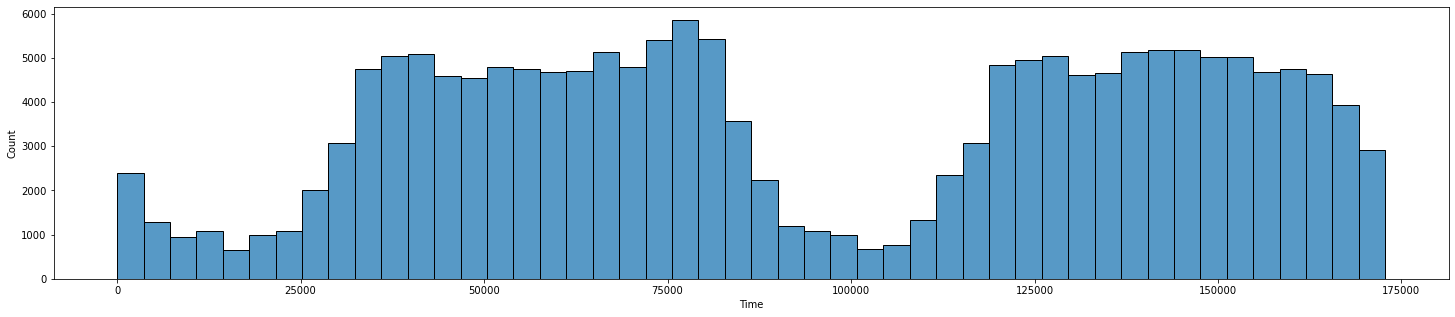

In [46]:
f, ax = plt.subplots(figsize=(25, 5))
sns.histplot(raw_train['Time'], bins = 48)

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- There are two periods when there is much more transactions done.
- $Time$ is in seconds from 0 to 172792 (so it is 2879,8 min -> about 48hours)
- We can assume that the modes are daytimes and the dataset describes two days

In [47]:
m = 172792/60 #minutes
h = m/60

print(f'Minutes {m}')
print(f'Hours: {h}')

Minutes 2879.866666666667
Hours: 47.99777777777778


# 4.6.1. Time distribution for the fraudulent transactions

In [48]:
len(df_fraud)

295

<AxesSubplot:xlabel='Time', ylabel='Count'>

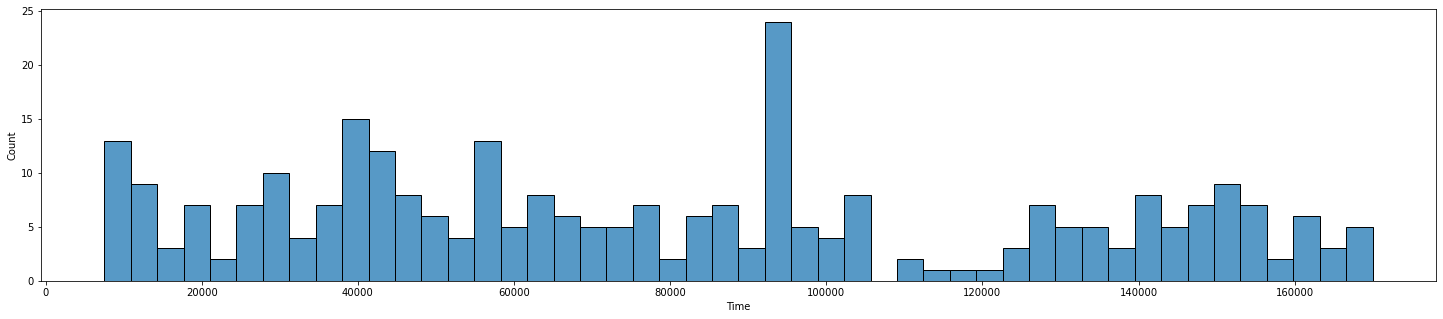

In [49]:
f, ax = plt.subplots(figsize=(25, 5))
sns.histplot(df_fraud['Time'], bins = 48)


### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- There are 295 fraudulent transactions in the training set
- There seems to be no real time pattern for the fraudulent transactions

## 4.6.2 $Time$ variable preprocessing to $hours$


In [50]:
# calculate the hour for each value in 'Time'
# // - Floor Division	9//2 = 4

train_t = raw_train
train_t['hour'] = ((((train_t['Time']) // (60 * 60)) % 24) + 1) # I calculate floor to get hours. As a result I get values from 0 to 47. Next I calulate modulo 24 -> I got values from 0 to 23. Last step adding 1 to get values from 1 to 24.
train_t['hour'] = train_t['hour'].astype(int)
print(train_t['hour'].min(), train_t['hour'].max())

1 24


<AxesSubplot:xlabel='Time', ylabel='hour'>

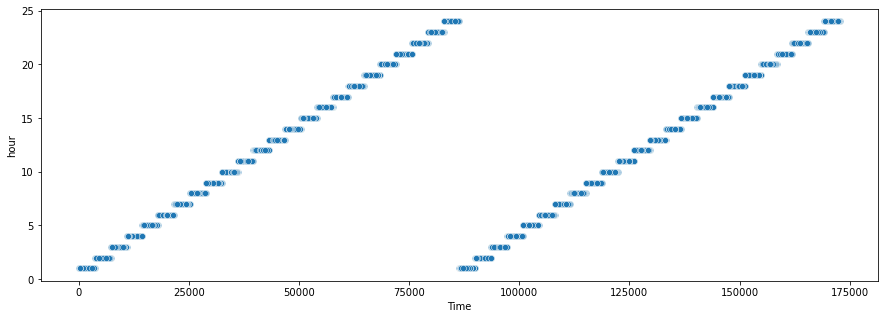

In [51]:
f, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(x=train_t['Time'], y=train_t['hour'], data=train_t)

# -------------------------------------------------------------------------------------------
# SCENARIOS: Model results on different data preprocessing ways
# -------------------------------------------------------------------------------------------

# ________________
# OUTLIERS_IN

Testing the models trained on data which:
 - **includes all the outliers**,
 - with variables $Amount$ and $Time$ scaled with MinMaXScaler(). $Time$ left as numeric.
 - labels was separated, no features dropped.

In [64]:
raw_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [65]:
imputer = SimpleImputer(strategy='most_frequent')
scaler_amount = MinMaxScaler()
scaler_time = MinMaxScaler()

In [66]:
clean_train_out = DataCleaner(hour=False, feature_to_drop=[], labels=True, imputer=imputer, amount_scaler=scaler_amount, time_scaler=scaler_time)

In [67]:
X_train_out, y_train_out = clean_train_out.fit_transform(raw_train)

In [68]:
X_train_out.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [69]:
X_val_out, y_val_out = clean_train_out.transform(raw_val)

In [70]:
rf_clf = RandomForestClassifier() #proba #featimp
brf_clf = BalancedRandomForestClassifier() #proba #featimp
lr_clf = LogisticRegression() #proba #coef
svc_rbf_clf = SVC(kernel='rbf', probability=True) #kernel #proba #coef 
svc_ploy_clf = SVC(kernel='poly', probability=True)
knn_clf = KNeighborsClassifier() #proba
gnb_clf = GaussianNB() #proba
ada_clf = AdaBoostClassifier() #proba #featimp
qda_clf = QuadraticDiscriminantAnalysis() #proba
mlp_clf = MLPClassifier() #coef #proba
xgb_clf = xgb.XGBClassifier() #featimp #coef #proba
xgbrf_clf = xgb.XGBRFClassifier() #featimp #coef #proba

In [71]:
model_names = ['rf_clf', 'brf_clf', 'lr_clf', 'svc_rbf_clf', 'svc_ploy_clf', 'knn_clf', 'gnb_clf', 'ada_clf',\
               'qda_clf', 'mlp_clf', 'xgb_clf', 'xgbrf_clf']
models = [rf_clf, brf_clf, lr_clf, svc_rbf_clf, svc_ploy_clf, knn_clf, gnb_clf, ada_clf, qda_clf, mlp_clf, xgb_clf, xgbrf_clf]

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9231    0.7347    0.8182        98

    accuracy                         0.9994     56961
   macro avg     0.9613    0.8673    0.9090     56961
weighted avg     0.9994    0.9994    0.9994     56961




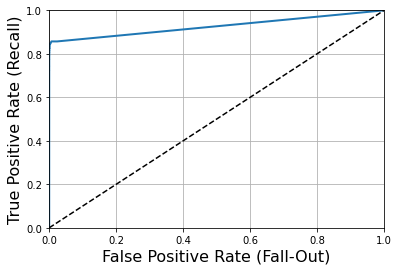

ROC AUC score: 0.9267523410187105

[[56857     6]
 [   26    72]]

============ brf_clf ============
None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9998    0.9731    0.9863     56863
           1     0.0533    0.8776    0.1004        98

    accuracy                         0.9729     56961
   macro avg     0.5265    0.9253    0.5433     56961
weighted avg     0.9982    0.9729    0.9847     56961




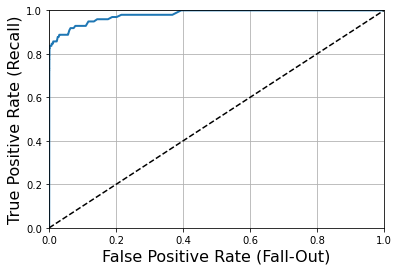

ROC AUC score: 0.9807789003788914

[[55334  1529]
 [   12    86]]

============ lr_clf ============


C:\Users\katar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56863
           1     0.8312    0.6531    0.7314        98

    accuracy                         0.9992     56961
   macro avg     0.9153    0.8264    0.8655     56961
weighted avg     0.9991    0.9992    0.9991     56961




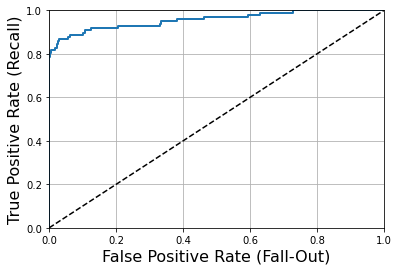

ROC AUC score: 0.9565181189159623

[[56850    13]
 [   34    64]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56863
           1     0.9545    0.6429    0.7683        98

    accuracy                         0.9993     56961
   macro avg     0.9770    0.8214    0.8840     56961
weighted avg     0.9993    0.9993    0.9993     56961




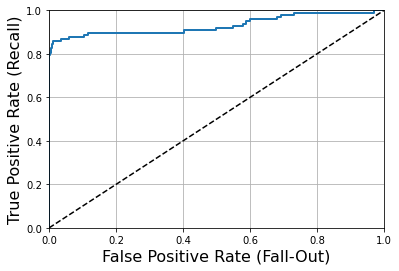

ROC AUC score: 0.9321467960766425

[[56860     3]
 [   35    63]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9333    0.7143    0.8092        98

    accuracy                         0.9994     56961
   macro avg     0.9664    0.8571    0.9045     56961
weighted avg     0.9994    0.9994    0.9994     56961




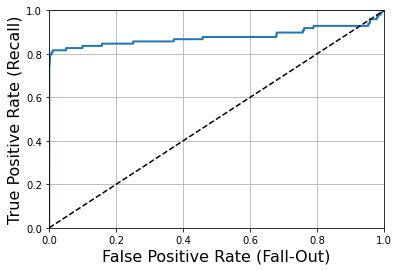

ROC AUC score: 0.8786079825947578

[[56858     5]
 [   28    70]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.8947    0.6939    0.7816        98

    accuracy                         0.9993     56961
   macro avg     0.9471    0.8469    0.8906     56961
weighted avg     0.9993    0.9993    0.9993     56961




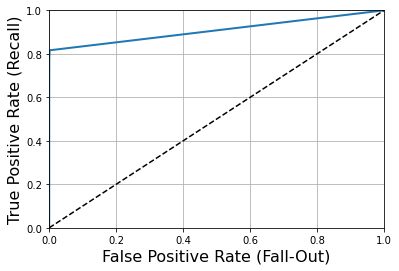

ROC AUC score: 0.9079935053352365

[[56855     8]
 [   30    68]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9778    0.9886     56863
           1     0.0590    0.8061    0.1100        98

    accuracy                         0.9775     56961
   macro avg     0.5293    0.8920    0.5493     56961
weighted avg     0.9980    0.9775    0.9871     56961




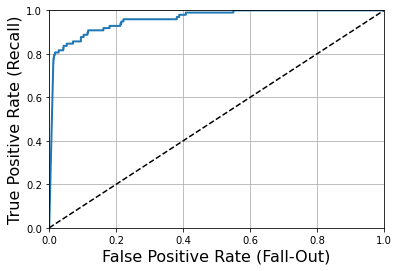

ROC AUC score: 0.959292868968631

[[55603  1260]
 [   19    79]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9997    0.9995     56863
           1     0.7895    0.6122    0.6897        98

    accuracy                         0.9991     56961
   macro avg     0.8944    0.8060    0.8446     56961
weighted avg     0.9990    0.9991    0.9990     56961




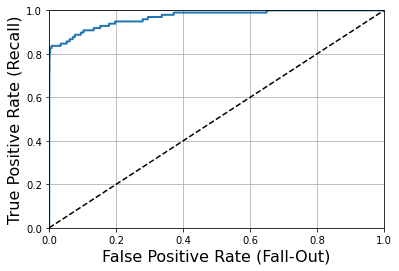

ROC AUC score: 0.9682215076910599

[[56847    16]
 [   38    60]]

============ qda_clf ============
'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9774    0.9884     56863
           1     0.0593    0.8265    0.1107        98

    accuracy                         0.9772     56961
   macro avg     0.5295    0.9020    0.5496     56961
weighted avg     0.9981    0.9772    0.9869     56961




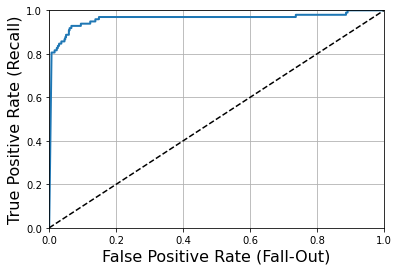

ROC AUC score: 0.9611954906296445

[[55579  1284]
 [   17    81]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9997     56863
           1     0.8734    0.7041    0.7797        98

    accuracy                         0.9993     56961
   macro avg     0.9365    0.8520    0.8897     56961
weighted avg     0.9993    0.9993    0.9993     56961




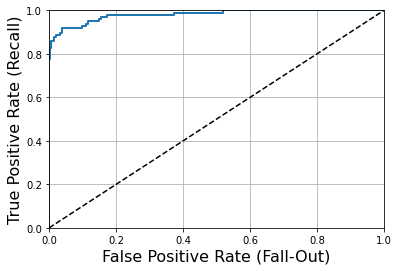

ROC AUC score: 0.9808140726350157

[[56853    10]
 [   29    69]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56863
           1     0.9481    0.7449    0.8343        98

    accuracy                         0.9995     56961
   macro avg     0.9738    0.8724    0.9170     56961
weighted avg     0.9995    0.9995    0.9995     56961




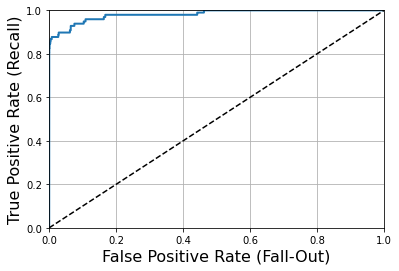

ROC AUC score: 0.9817556482874881

[[56859     4]
 [   25    73]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8636    0.7755    0.8172        98

    accuracy                         0.9994     56961
   macro avg     0.9316    0.8876    0.9085     56961
weighted avg     0.9994    0.9994    0.9994     56961




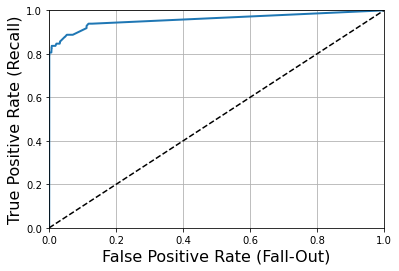

ROC AUC score: 0.9582779878741854

[[56851    12]
 [   22    76]]



In [72]:
eval_dict_out = dict()

for i, m in enumerate(models):
    eval_dict_out[model_names[i]] = model_tester(m, model_names[i], X_train_out, y_train_out, X_val_out, y_val_out)

In [73]:
eval_df_out = pd.DataFrame(data=eval_dict_out.values(), index=eval_dict_out.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [74]:
eval_df_out

,bal_acc_score,precisions,recalls,f1,false_positives,false_negatives,train_time,test_time
rf_clf,0.867294,0.923077,0.734694,0.818182,6,26,130.573742,0.497263
brf_clf,0.925331,0.053251,0.877551,0.100409,1529,12,4.335241,0.357054
lr_clf,0.826416,0.831169,0.653061,0.731429,13,34,1.995478,0.005009
svc_rbf_clf,0.821402,0.954545,0.642857,0.768293,3,35,1091.749840,14.439526
svc_ploy_clf,0.857099,0.933333,0.714286,0.809249,5,28,101.040714,1.487049
knn_clf,0.846868,0.894737,0.693878,0.781609,8,30,0.036005,195.664196
gnb_clf,0.891982,0.058999,0.806122,0.109951,1260,19,0.123757,0.051848
ada_clf,0.805982,0.789474,0.612245,0.689655,16,38,39.948171,0.449790
qda_clf,0.901975,0.059341,0.826531,0.110731,1284,17,0.382446,0.046874
mlp_clf,0.851953,0.873418,0.704082,0.779661,10,29,41.458953,0.062582


# ________________
# $Time$ as categorical variable -> $hours$

Testing the models trained on data which:
 - $Time$ changed into categorical variable $hours$,
 - includes all the outliers,
 - with variables $Amount$ scaled with MinMaxScaler(). 
 - labels was separated, no features dropped.

In [77]:
scaler = MinMaxScaler()

In [78]:
clean_train_h = DataCleaner(hour=True, feature_to_drop=[], labels=True, amount_scaler=scaler)

In [79]:
X_train_h, y_train_h = clean_train_h.fit_transform(raw_train)

In [80]:
X_train_h.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'hour_24'],
      dtype='object')

In [81]:
X_val_h, y_val_h = clean_train_h.transform(raw_val)

In [82]:
rf_clf = RandomForestClassifier() #proba #featimp
brf_clf = BalancedRandomForestClassifier() #proba #featimp
lr_clf = LogisticRegression() #proba #coef
svc_rbf_clf = SVC(kernel='rbf', probability=True) #kernel #proba #coef 
svc_ploy_clf = SVC(kernel='poly', probability=True)
knn_clf = KNeighborsClassifier() #proba
gnb_clf = GaussianNB() #proba
ada_clf = AdaBoostClassifier() #proba #featimp
qda_clf = QuadraticDiscriminantAnalysis() #proba
mlp_clf = MLPClassifier() #coef #proba
xgb_clf = xgb.XGBClassifier() #featimp #coef #proba
xgbrf_clf = xgb.XGBRFClassifier() #featimp #coef #proba

In [83]:
model_names = ['rf_clf', 'brf_clf', 'lr_clf', 'svc_rbf_clf', 'svc_ploy_clf', 'knn_clf', 'gnb_clf', 'ada_clf',\
               'qda_clf', 'mlp_clf', 'xgb_clf', 'xgbrf_clf']
models = [rf_clf, brf_clf, lr_clf, svc_rbf_clf, svc_ploy_clf, knn_clf, gnb_clf, ada_clf, qda_clf, mlp_clf, xgb_clf, xgbrf_clf]

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9342    0.7245    0.8161        98

    accuracy                         0.9994     56961
   macro avg     0.9669    0.8622    0.9079     56961
weighted avg     0.9994    0.9994    0.9994     56961




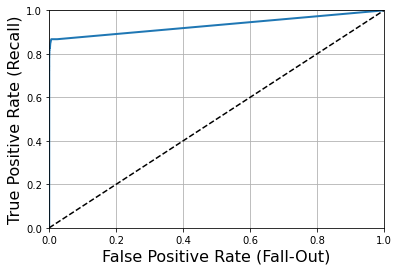

ROC AUC score: 0.9318833630562824

[[56858     5]
 [   27    71]]

============ brf_clf ============
None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9998    0.9795    0.9895     56863
           1     0.0678    0.8673    0.1258        98

    accuracy                         0.9793     56961
   macro avg     0.5338    0.9234    0.5577     56961
weighted avg     0.9982    0.9793    0.9880     56961




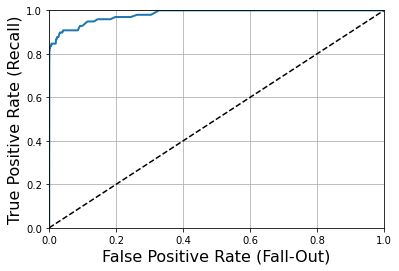

ROC AUC score: 0.9816984036461427

[[55695  1168]
 [   13    85]]

============ lr_clf ============


C:\Users\katar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56863
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56961
   macro avg     0.9142    0.8213    0.8619     56961
weighted avg     0.9991    0.9992    0.9991     56961




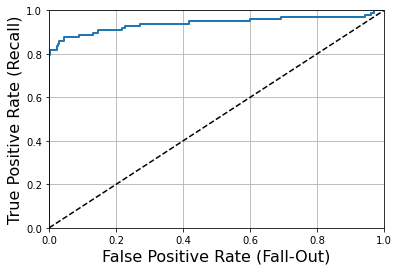

ROC AUC score: 0.9401215668019841

[[56850    13]
 [   35    63]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56863
           1     0.9545    0.6429    0.7683        98

    accuracy                         0.9993     56961
   macro avg     0.9770    0.8214    0.8840     56961
weighted avg     0.9993    0.9993    0.9993     56961




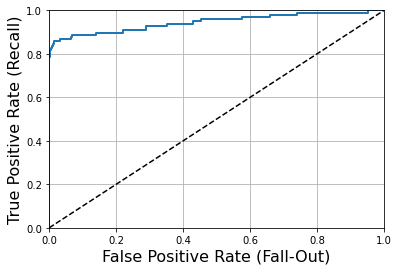

ROC AUC score: 0.9457396169167066

[[56860     3]
 [   35    63]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9452    0.7041    0.8070        98

    accuracy                         0.9994     56961
   macro avg     0.9723    0.8520    0.9034     56961
weighted avg     0.9994    0.9994    0.9994     56961




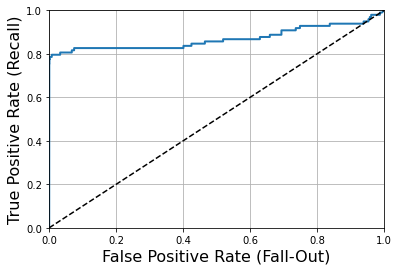

ROC AUC score: 0.8694631960024218

[[56859     4]
 [   29    69]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.8947    0.6939    0.7816        98

    accuracy                         0.9993     56961
   macro avg     0.9471    0.8469    0.8906     56961
weighted avg     0.9993    0.9993    0.9993     56961




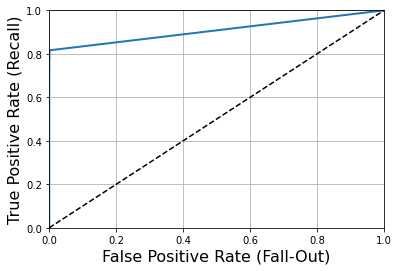

ROC AUC score: 0.9079804951894762

[[56855     8]
 [   30    68]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9587    0.9788     56863
           1     0.0326    0.8061    0.0626        98

    accuracy                         0.9585     56961
   macro avg     0.5161    0.8824    0.5207     56961
weighted avg     0.9980    0.9585    0.9772     56961




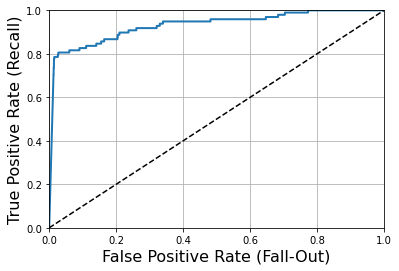

ROC AUC score: 0.9314905463794649

[[54517  2346]
 [   19    79]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9997    0.9995     56863
           1     0.7750    0.6327    0.6966        98

    accuracy                         0.9991     56961
   macro avg     0.8872    0.8162    0.8481     56961
weighted avg     0.9990    0.9991    0.9990     56961




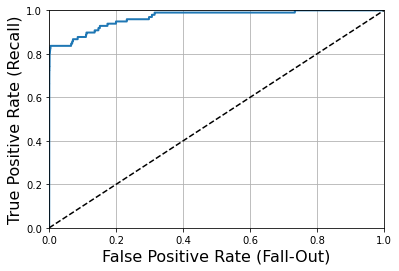

ROC AUC score: 0.967029598889131

[[56845    18]
 [   36    62]]

============ qda_clf ============


C:\Users\katar\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9651    0.9821     56863
           1     0.0388    0.8163    0.0740        98

    accuracy                         0.9649     56961
   macro avg     0.5192    0.8907    0.5281     56961
weighted avg     0.9980    0.9649    0.9805     56961




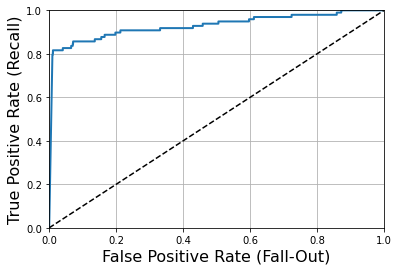

ROC AUC score: 0.9296029985425047

[[54880  1983]
 [   18    80]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.8987    0.7245    0.8023        98

    accuracy                         0.9994     56961
   macro avg     0.9491    0.8622    0.9010     56961
weighted avg     0.9994    0.9994    0.9994     56961




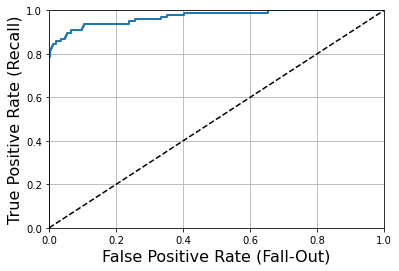

ROC AUC score: 0.9709380261258083

[[56855     8]
 [   27    71]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56863
           1     0.9375    0.7653    0.8427        98

    accuracy                         0.9995     56961
   macro avg     0.9685    0.8826    0.9212     56961
weighted avg     0.9995    0.9995    0.9995     56961




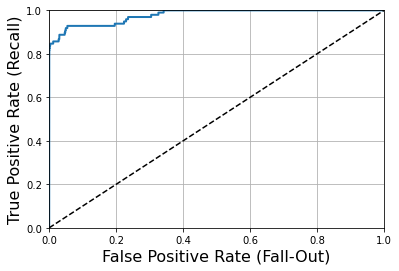

ROC AUC score: 0.9779187319899207

[[56858     5]
 [   23    75]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8750    0.7857    0.8280        98

    accuracy                         0.9994     56961
   macro avg     0.9373    0.8928    0.9138     56961
weighted avg     0.9994    0.9994    0.9994     56961




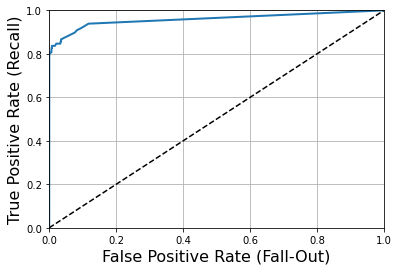

ROC AUC score: 0.9590715170404198

[[56852    11]
 [   21    77]]



In [86]:
eval_dict_h = dict()

for i, m in enumerate(models):
    eval_dict_h[model_names[i]] = model_tester(m, model_names[i],X_train_h, y_train_h, X_val_h, y_val_h )

In [87]:
eval_df_h = pd.DataFrame(data=eval_dict_h.values(), index=eval_dict_h.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [88]:
eval_df_h

,bal_acc_score,precisions,recalls,f1,false_positives,false_negatives,train_time,test_time
rf_clf,0.862201,0.934211,0.724490,0.816092,5,27,104.563767,0.617429
brf_clf,0.923403,0.067837,0.867347,0.125833,1168,13,3.868179,0.365802
lr_clf,0.821314,0.828947,0.642857,0.724138,13,35,2.143582,0.018984
svc_rbf_clf,0.821402,0.954545,0.642857,0.768293,3,35,1077.113693,14.901546
svc_ploy_clf,0.852006,0.945205,0.704082,0.807018,4,29,139.982798,1.241239
knn_clf,0.846868,0.894737,0.693878,0.781609,8,30,0.042538,174.217469
gnb_clf,0.882433,0.032577,0.806122,0.062624,2346,19,0.246070,0.072031
ada_clf,0.816168,0.775000,0.632653,0.696629,18,36,37.817489,0.622485
qda_clf,0.890727,0.038778,0.816327,0.074040,1983,18,0.612738,0.083278
mlp_clf,0.862175,0.898734,0.724490,0.802260,8,27,62.888356,0.083046


# ________________
# $Amount$ as $log$

As distribution of $Amount$ is skewed we test whether transforming the variable with logaritmic function will have any positive effect on the models results.

 - $Time$ changed into categorical variable $hours$,
 - $Amount$  log transformed and scaled with MinMaxScaler(). 
 - labels was separated, no features dropped.


In [89]:
clean_train_log = DataCleaner(hour=True,feature_to_drop=['Amount'], labels=True, amount_scaler=scaler, amount_log = True)

In [90]:
X_train_log, y_train_log = clean_train_log.fit_transform(raw_train)

In [91]:
X_train_log.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'hour_24'],
      dtype='object')

In [92]:
X_val_log, y_val_log = clean_train_log.transform(raw_val)

In [93]:
X_val_log.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'hour_24'],
      dtype='object')

In [94]:
rf_clf = RandomForestClassifier() #proba #featimp
brf_clf = BalancedRandomForestClassifier() #proba #featimp
lr_clf = LogisticRegression() #proba #coef
svc_rbf_clf = SVC(kernel='rbf', probability=True) #kernel #proba #coef 
svc_ploy_clf = SVC(kernel='poly', probability=True)
knn_clf = KNeighborsClassifier() #proba
gnb_clf = GaussianNB() #proba
ada_clf = AdaBoostClassifier() #proba #featimp
qda_clf = QuadraticDiscriminantAnalysis() #proba
mlp_clf = MLPClassifier() #coef #proba
xgb_clf = xgb.XGBClassifier() #featimp #coef #proba
xgbrf_clf = xgb.XGBRFClassifier() #featimp #coef #proba

In [95]:
model_names = ['rf_clf', 'brf_clf', 'lr_clf', 'svc_rbf_clf', 'svc_ploy_clf', 'knn_clf', 'gnb_clf', 'ada_clf',\
               'qda_clf', 'mlp_clf', 'xgb_clf', 'xgbrf_clf']
models = [rf_clf, brf_clf, lr_clf, svc_rbf_clf, svc_ploy_clf, knn_clf, gnb_clf, ada_clf, qda_clf, mlp_clf, xgb_clf, xgbrf_clf]

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9351    0.7347    0.8229        98

    accuracy                         0.9995     56961
   macro avg     0.9673    0.8673    0.9113     56961
weighted avg     0.9994    0.9995    0.9994     56961




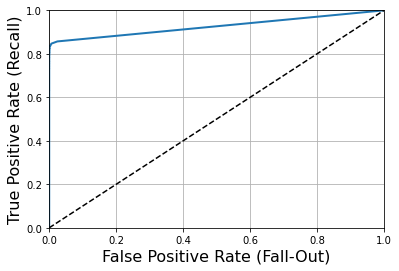

ROC AUC score: 0.9265466012654117

[[56858     5]
 [   26    72]]

============ brf_clf ============
None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9816    0.9906     56863
           1     0.0735    0.8469    0.1352        98

    accuracy                         0.9814     56961
   macro avg     0.5366    0.9143    0.5629     56961
weighted avg     0.9981    0.9814    0.9891     56961




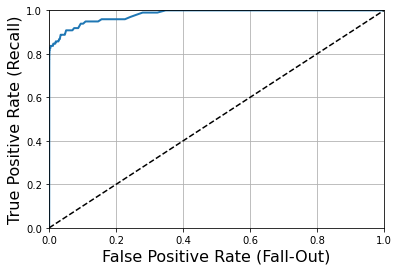

ROC AUC score: 0.9812251035158976

[[55816  1047]
 [   15    83]]

============ lr_clf ============


C:\Users\katar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56863
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56961
   macro avg     0.9142    0.8213    0.8619     56961
weighted avg     0.9991    0.9992    0.9991     56961




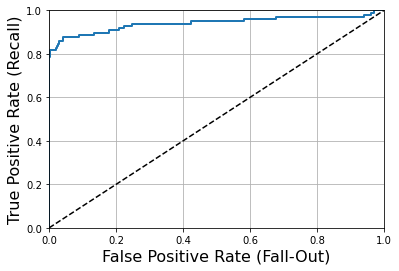

ROC AUC score: 0.9404519347791522

[[56850    13]
 [   35    63]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56863
           1     0.9545    0.6429    0.7683        98

    accuracy                         0.9993     56961
   macro avg     0.9770    0.8214    0.8840     56961
weighted avg     0.9993    0.9993    0.9993     56961




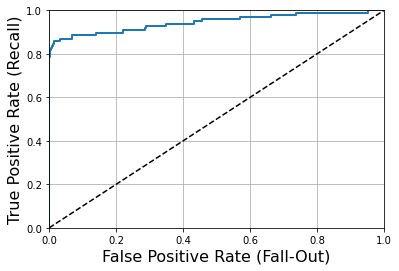

ROC AUC score: 0.9458113970312462

[[56860     3]
 [   35    63]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9452    0.7041    0.8070        98

    accuracy                         0.9994     56961
   macro avg     0.9723    0.8520    0.9034     56961
weighted avg     0.9994    0.9994    0.9994     56961




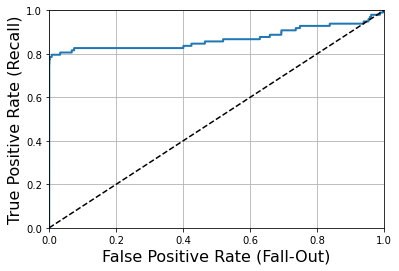

ROC AUC score: 0.8694579919441177

[[56859     4]
 [   29    69]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.8947    0.6939    0.7816        98

    accuracy                         0.9993     56961
   macro avg     0.9471    0.8469    0.8906     56961
weighted avg     0.9993    0.9993    0.9993     56961




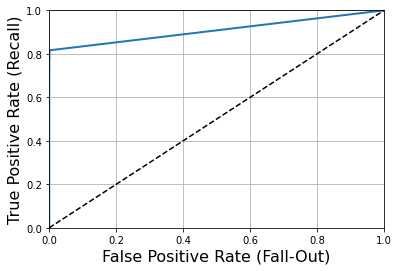

ROC AUC score: 0.9079804951894762

[[56855     8]
 [   30    68]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9589    0.9789     56863
           1     0.0327    0.8061    0.0629        98

    accuracy                         0.9587     56961
   macro avg     0.5162    0.8825    0.5209     56961
weighted avg     0.9980    0.9587    0.9773     56961




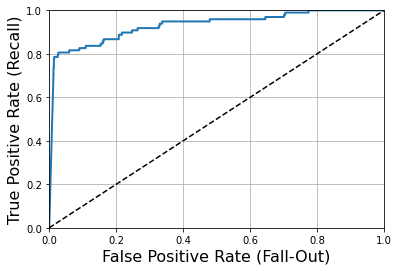

ROC AUC score: 0.93091549793686

[[54528  2335]
 [   19    79]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9996    0.9995     56863
           1     0.7442    0.6531    0.6957        98

    accuracy                         0.9990     56961
   macro avg     0.8718    0.8263    0.8476     56961
weighted avg     0.9990    0.9990    0.9990     56961




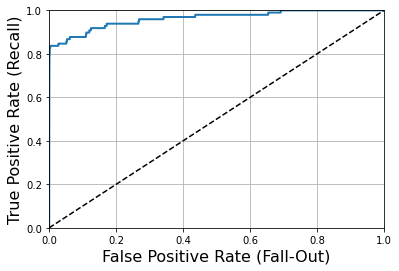

ROC AUC score: 0.9625036832171273

[[56841    22]
 [   34    64]]

============ qda_clf ============


C:\Users\katar\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9690    0.9841     56863
           1     0.0435    0.8163    0.0826        98

    accuracy                         0.9688     56961
   macro avg     0.5216    0.8927    0.5333     56961
weighted avg     0.9980    0.9688    0.9826     56961




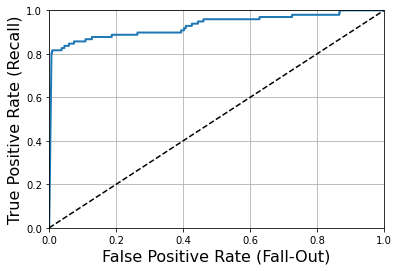

ROC AUC score: 0.9306588840273812

[[55103  1760]
 [   18    80]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8690    0.7449    0.8022        98

    accuracy                         0.9994     56961
   macro avg     0.9343    0.8724    0.9009     56961
weighted avg     0.9993    0.9994    0.9993     56961




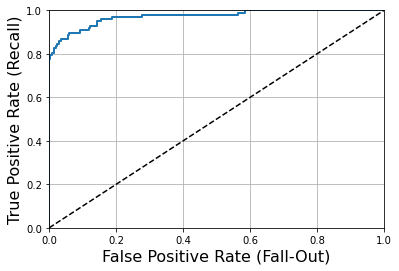

ROC AUC score: 0.9723869077377886

[[56852    11]
 [   25    73]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56863
           1     0.9375    0.7653    0.8427        98

    accuracy                         0.9995     56961
   macro avg     0.9685    0.8826    0.9212     56961
weighted avg     0.9995    0.9995    0.9995     56961




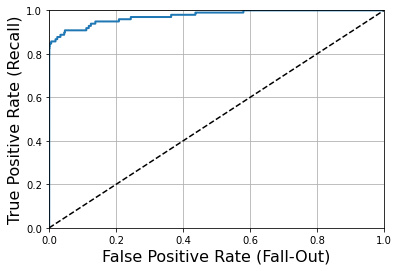

ROC AUC score: 0.9744487915279366

[[56858     5]
 [   23    75]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8750    0.7857    0.8280        98

    accuracy                         0.9994     56961
   macro avg     0.9373    0.8928    0.9138     56961
weighted avg     0.9994    0.9994    0.9994     56961




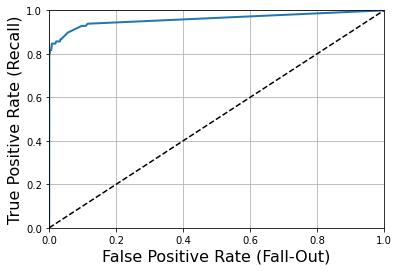

ROC AUC score: 0.960120583414415

[[56852    11]
 [   21    77]]



In [96]:
eval_dict_log = dict()

for i, m in enumerate(models):
    eval_dict_log[model_names[i]] = model_tester(m, model_names[i], X_train_log, y_train_log, X_val_log, y_val_log)

In [97]:
eval_df_log = pd.DataFrame(data=eval_dict_log.values(), index=eval_dict_log.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [98]:
eval_df_log

,bal_acc_score,precisions,recalls,f1,false_positives,false_negatives,train_time,test_time
rf_clf,0.867303,0.935065,0.734694,0.822857,5,26,89.720069,0.504611
brf_clf,0.914263,0.073451,0.846939,0.135179,1047,15,3.806854,0.416713
lr_clf,0.821314,0.828947,0.642857,0.724138,13,35,2.072351,0.020131
svc_rbf_clf,0.821402,0.954545,0.642857,0.768293,3,35,1019.680052,14.087690
svc_ploy_clf,0.852006,0.945205,0.704082,0.807018,4,29,135.042476,1.020751
knn_clf,0.846868,0.894737,0.693878,0.781609,8,30,0.038700,168.275509
gnb_clf,0.882529,0.032726,0.806122,0.062898,2335,19,2.581858,2.797665
ada_clf,0.826337,0.744186,0.653061,0.695652,22,34,36.970082,0.679163
qda_clf,0.892687,0.043478,0.816327,0.082559,1760,18,0.504314,0.079420
mlp_clf,0.872352,0.869048,0.744898,0.802198,11,25,55.498455,0.090892


# _____________________
# Dataset testing: Time scaled → MinMax, Amount scaled → Robust

In [ ]:
amount_scaler = RobustScaler()
time_scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
clean_train_r = DataCleaner(hour=False, feature_to_drop=[], labels=True, amount_scaler=amount_scaler, time_scaler=time_scaler)

In [ ]:
X_train_time_amt_robust, y_train = clean_train_r.fit_transform(raw_train)

In [ ]:
X_val_time_amt_robust, y_val = clean_train.transform(raw_val)

In [ ]:
rf_clf = RandomForestClassifier() #proba #featimp
brf_clf = BalancedRandomForestClassifier() #proba #featimp
lr_clf = LogisticRegression() #proba #coef
svc_rbf_clf = SVC(kernel='rbf', probability=True) #kernel #proba #coef 
svc_ploy_clf = SVC(kernel='poly', probability=True)
knn_clf = KNeighborsClassifier() #proba
gnb_clf = GaussianNB() #proba
ada_clf = AdaBoostClassifier() #proba #featimp
qda_clf = QuadraticDiscriminantAnalysis() #proba
mlp_clf = MLPClassifier() #coef #proba
xgb_clf = xgb.XGBClassifier() #featimp #coef #proba
xgbrf_clf = xgb.XGBRFClassifier() #featimp #coef #proba

In [ ]:
model_names = ['rf_clf', 'brf_clf', 'lr_clf', 'svc_rbf_clf', 'svc_ploy_clf', 'knn_clf', 'gnb_clf', 'ada_clf',\
               'qda_clf', 'mlp_clf', 'xgb_clf', 'xgbrf_clf']
models = [rf_clf, brf_clf, lr_clf, svc_rbf_clf, svc_ploy_clf, knn_clf, gnb_clf, ada_clf, qda_clf, mlp_clf, xgb_clf, xgbrf_clf]

In [ ]:
eval_dict_time = dict()

for i, m in enumerate(models):
    eval_dict_time[model_names[i]] = model_tester(m, model_names[i], X_train=X_train_time_amt_robust, y_train=y_train,\
                                             X_val=X_val_time_amt_robust, y_val=y_val)

In [ ]:
eval_df_time = pd.DataFrame(data=eval_dict_time.values(), index=eval_dict_time.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [ ]:
eval_df_time

# ___________________________
# Dataset testing: Hours, Amount scaled → Robust

In [ ]:
amount_scaler = RobustScaler()
clean_train_hour = DataCleaner(hour=True, feature_to_drop=[], labels=True, \
                          amount_scaler=amount_scaler, time_scaler=None)

In [ ]:
X_train_hour_amt_robust, y_train = clean_train_hour.fit_transform(raw_train)

In [ ]:
X_train_hour_amt_robust.columns

In [ ]:
X_val_hour_amt_robust, y_val = clean_train_hour.transform(raw_val)

In [ ]:
rf_clf = RandomForestClassifier() #proba #featimp
brf_clf = BalancedRandomForestClassifier() #proba #featimp
lr_clf = LogisticRegression() #proba #coef
svc_rbf_clf = SVC(kernel='rbf', probability=True) #kernel #proba #coef 
svc_ploy_clf = SVC(kernel='poly', probability=True)
knn_clf = KNeighborsClassifier() #proba
gnb_clf = GaussianNB() #proba
ada_clf = AdaBoostClassifier() #proba #featimp
qda_clf = QuadraticDiscriminantAnalysis() #proba
mlp_clf = MLPClassifier() #coef #proba
xgb_clf = xgb.XGBClassifier() #featimp #coef #proba
xgbrf_clf = xgb.XGBRFClassifier() #featimp #coef #proba

In [ ]:
model_names = ['rf_clf', 'brf_clf', 'lr_clf', 'svc_rbf_clf', 'svc_ploy_clf', 'knn_clf', 'gnb_clf', 'ada_clf',\
               'qda_clf', 'mlp_clf', 'xgb_clf', 'xgbrf_clf']
models = [rf_clf, brf_clf, lr_clf, svc_rbf_clf, svc_ploy_clf, knn_clf, gnb_clf, ada_clf, qda_clf, mlp_clf, xgb_clf, xgbrf_clf]

In [ ]:
eval_dict_rob = dict()

for i, m in enumerate(models):
    eval_dict_rob[model_names[i]] = model_tester(m, model_names[i], X_train=X_train_hour_amt_robust, y_train=y_train,\
                                             X_val=X_val_hour_amt_robust, y_val=y_val)

In [ ]:
eval_df_rob = pd.DataFrame(data=eval_dict_rob.values(), index=eval_dict_rob.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [ ]:
eval_df_rob

# _________________________
# Dataset testing: Hours, Amount scaled → Robust, Log

In [18]:
amount_scaler = RobustScaler()
clean_train_hour_log = DataCleaner(hour=True, feature_to_drop=[], labels=True, \
                          amount_scaler=amount_scaler, time_scaler=None, amount_log=True)

In [19]:
X_train_hour_amt_robust_log, y_train = clean_train_hour_log.fit_transform(raw_train)

In [20]:
X_train_hour_amt_robust_log.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'hour_24'],
      dtype='object')

In [21]:
X_val_hour_amt_robust_log, y_val = clean_train_hour_log.transform(raw_val)

In [22]:
rf_clf = RandomForestClassifier() #proba #featimp
brf_clf = BalancedRandomForestClassifier() #proba #featimp
lr_clf = LogisticRegression() #proba #coef
svc_rbf_clf = SVC(kernel='rbf', probability=True) #kernel #proba #coef 
svc_ploy_clf = SVC(kernel='poly', probability=True)
knn_clf = KNeighborsClassifier() #proba
gnb_clf = GaussianNB() #proba
ada_clf = AdaBoostClassifier() #proba #featimp
qda_clf = QuadraticDiscriminantAnalysis() #proba
mlp_clf = MLPClassifier() #coef #proba
xgb_clf = xgb.XGBClassifier() #featimp #coef #proba
xgbrf_clf = xgb.XGBRFClassifier() #featimp #coef #proba

In [23]:
model_names = ['rf_clf', 'brf_clf', 'lr_clf', 'svc_rbf_clf', 'svc_ploy_clf', 'knn_clf', 'gnb_clf', 'ada_clf',\
               'qda_clf', 'mlp_clf', 'xgb_clf', 'xgbrf_clf']
models = [rf_clf, brf_clf, lr_clf, svc_rbf_clf, svc_ploy_clf, knn_clf, gnb_clf, ada_clf, qda_clf, mlp_clf, xgb_clf, xgbrf_clf]

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9221    0.7245    0.8114        98

    accuracy                         0.9994     56961
   macro avg     0.9608    0.8622    0.9056     56961
weighted avg     0.9994    0.9994    0.9994     56961




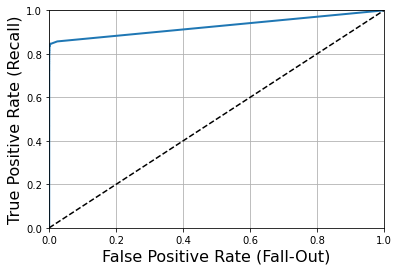

ROC AUC score: 0.9266165868770877

[[56857     6]
 [   27    71]]

============ brf_clf ============
None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9998    0.9776    0.9886     56863
           1     0.0626    0.8673    0.1168        98

    accuracy                         0.9774     56961
   macro avg     0.5312    0.9225    0.5527     56961
weighted avg     0.9982    0.9774    0.9871     56961




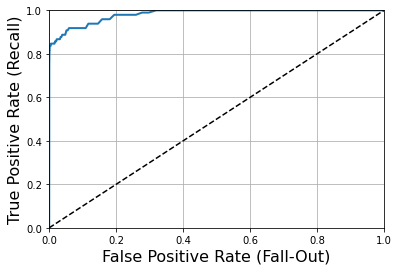

ROC AUC score: 0.9819431738367225

[[55591  1272]
 [   13    85]]

============ lr_clf ============


C:\Users\katar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56863
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56961
   macro avg     0.9142    0.8213    0.8619     56961
weighted avg     0.9991    0.9992    0.9991     56961




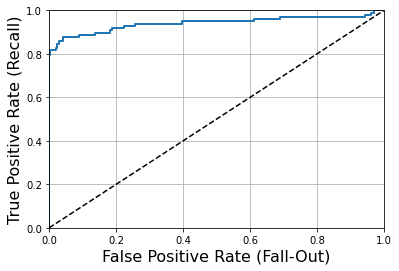

ROC AUC score: 0.940335471543312

[[56850    13]
 [   35    63]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56863
           1     0.9545    0.6429    0.7683        98

    accuracy                         0.9993     56961
   macro avg     0.9770    0.8214    0.8840     56961
weighted avg     0.9993    0.9993    0.9993     56961




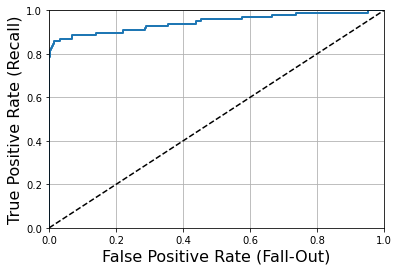

ROC AUC score: 0.945701214555428

[[56860     3]
 [   35    63]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9452    0.7041    0.8070        98

    accuracy                         0.9994     56961
   macro avg     0.9723    0.8520    0.9034     56961
weighted avg     0.9994    0.9994    0.9994     56961




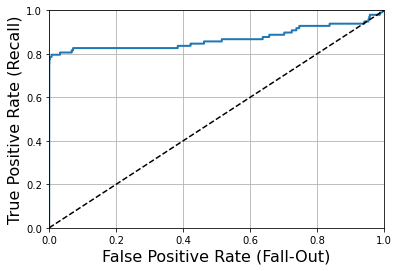

ROC AUC score: 0.8693545388540376

[[56859     4]
 [   29    69]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.8947    0.6939    0.7816        98

    accuracy                         0.9993     56961
   macro avg     0.9471    0.8469    0.8906     56961
weighted avg     0.9993    0.9993    0.9993     56961




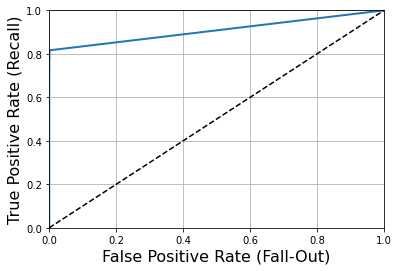

ROC AUC score: 0.9079804951894762

[[56855     8]
 [   30    68]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9589    0.9789     56863
           1     0.0327    0.8061    0.0629        98

    accuracy                         0.9587     56961
   macro avg     0.5162    0.8825    0.5209     56961
weighted avg     0.9980    0.9587    0.9773     56961




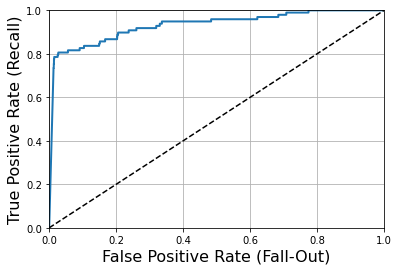

ROC AUC score: 0.9318052124565775

[[54527  2336]
 [   19    79]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9997    0.9995     56863
           1     0.7750    0.6327    0.6966        98

    accuracy                         0.9991     56961
   macro avg     0.8872    0.8162    0.8481     56961
weighted avg     0.9990    0.9991    0.9990     56961




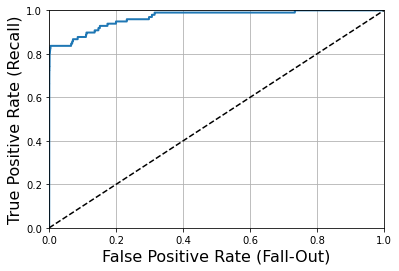

ROC AUC score: 0.967029598889131

[[56845    18]
 [   36    62]]

============ qda_clf ============


C:\Users\katar\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9373    0.9675     56863
           1     0.0222    0.8265    0.0432        98

    accuracy                         0.9371     56961
   macro avg     0.5109    0.8819    0.5054     56961
weighted avg     0.9980    0.9371    0.9659     56961




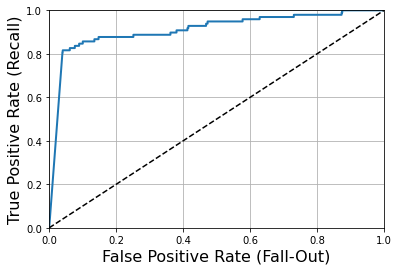

ROC AUC score: 0.9116024300439977

[[53296  3567]
 [   17    81]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9079    0.7041    0.7931        98

    accuracy                         0.9994     56961
   macro avg     0.9537    0.8520    0.8964     56961
weighted avg     0.9993    0.9994    0.9993     56961




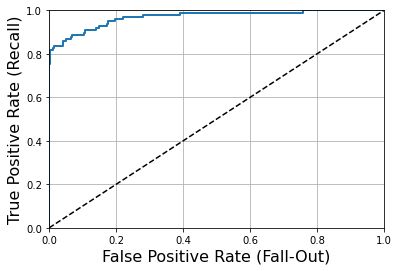

ROC AUC score: 0.9694057001306757

[[56856     7]
 [   29    69]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56863
           1     0.9375    0.7653    0.8427        98

    accuracy                         0.9995     56961
   macro avg     0.9685    0.8826    0.9212     56961
weighted avg     0.9995    0.9995    0.9995     56961




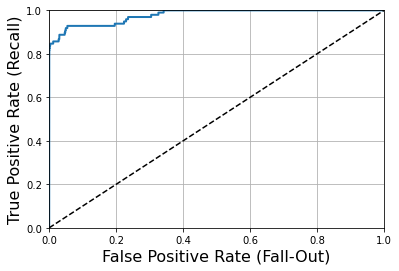

ROC AUC score: 0.9779187319899207

[[56858     5]
 [   23    75]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8750    0.7857    0.8280        98

    accuracy                         0.9994     56961
   macro avg     0.9373    0.8928    0.9138     56961
weighted avg     0.9994    0.9994    0.9994     56961




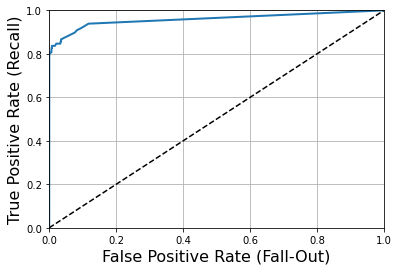

ROC AUC score: 0.9590715170404198

[[56852    11]
 [   21    77]]



In [106]:
eval_dict_hours_log = dict()

for i, m in enumerate(models):
    eval_dict_hours_log[model_names[i]] = model_tester(m, model_names[i], X_train=X_train_hour_amt_robust_log, y_train=y_train,\
                                                       X_val=X_val_hour_amt_robust_log, y_val=y_val) 

In [107]:
eval_df_hour_log = pd.DataFrame(data=eval_dict_hours_log.values(), index=eval_dict_hours_log.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [108]:
eval_df_hour_log

,bal_acc_score,precisions,recalls,f1,false_positives,false_negatives,train_time,test_time
rf_clf,0.862192,0.922078,0.724490,0.811429,6,27,92.057036,0.501951
brf_clf,0.922489,0.062638,0.867347,0.116838,1272,13,3.836803,0.368807
lr_clf,0.821314,0.828947,0.642857,0.724138,13,35,2.137877,0.028337
svc_rbf_clf,0.821402,0.954545,0.642857,0.768293,3,35,970.888923,15.698457
svc_ploy_clf,0.852006,0.945205,0.704082,0.807018,4,29,153.127962,1.113045
knn_clf,0.846868,0.894737,0.693878,0.781609,8,30,0.040004,187.106835
gnb_clf,0.882521,0.032712,0.806122,0.062873,2336,19,13.679539,0.073118
ada_clf,0.816168,0.775000,0.632653,0.696629,18,36,41.417355,0.716515
qda_clf,0.881900,0.022204,0.826531,0.043246,3567,17,0.639469,0.091055
mlp_clf,0.851979,0.907895,0.704082,0.793103,7,29,50.317804,0.079576


# ______________________
# Mutual information on Hours-Amount(Robust/Log)

In [114]:
from sklearn.feature_selection import mutual_info_regression


# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.columns:
        mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=0)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
mi_scores_hour_rob_log = make_mi_scores(X=X_train_hour_amt_robust_log, y=y_train)

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
plot_mi_scores(mi_scores_hour_rob_log)

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
plot_mi_scores(mi_scores_hour_rob_log)

# __________________
# "unimportant" features removed

In [ ]:
features_with_zero_mutual_info = mi_scores_hour_rob_log[~(mi_scores_hour_rob_log>0)].index

In [ ]:
X_train_pruned = X_train_hour_amt_robust_log.drop(features_with_zero_mutual_info, axis=1)
X_val_pruned = X_val_hour_amt_robust_log.drop(features_with_zero_mutual_info, axis=1)
X_train_pruned

In [ ]:
eval_dict_hours_log_pruned = dict()

for i, m in enumerate(models):
    eval_dict_hours_log_pruned[model_names[i]] = model_tester(m, model_names[i], X_train=X_train_pruned, y_train=y_train,\
                                                       X_val=X_val_pruned, y_val=y_val)  

In [ ]:
eval_df_hour_log_pruned = pd.DataFrame(data=eval_dict_hours_log_pruned.values(), index=eval_dict_hours_log_pruned.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [ ]:
eval_df_hour_log_pruned

In [ ]:
eval_df_hour_log_pruned - eval_df_hour_log

# CHECKING NEW METRICS

In [36]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score, recall_score


def model_tester2(clf, clf_name, X_train, y_train, X_val, y_val):
    print(f'============ {clf_name} ============')
    
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = clf.predict(X_val)
    test_time = time.time() - start_time
    
    print(metrics.classification_report(y_val, y_pred, digits=4), end='\n\n===============================================\n')
    
    # balanced accuracy score
    bal_acc_score = balanced_accuracy_score(y_val, y_pred)
    
    # Recall -Precision plot
    y_prob = clf.predict_proba(X_val)[:, 1]
    precision_prob, recall_prob, threshold_prob = precision_recall_curve(y_val, y_prob)
    plt.plot(recall_prob, precision_prob)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    
    # Precision and recall to include in the results
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    
    # Fbeta metric    
    fbeta =fbeta_score(y_val, y_pred, average='binary', beta=10, pos_label=1)
    print('fbeta: %.4f' % fbeta, end='\n')
    
    # AUC under the Recall-Precision 
    auc_score = auc(recall_prob, precision_prob)
    print('AUC: %.3f' % auc_score, end='\n')
    
    conf_mtr = confusion_matrix(y_val, y_pred)
    print(conf_mtr, end='\n\n===============================================\n')
    
    return [fbeta, bal_acc_score, precision, recall, auc_score, conf_mtr[0,1], conf_mtr[1,0], train_time, test_time]

============ lr ============


C:\Users\katar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56863
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56961
   macro avg     0.9142    0.8213    0.8619     56961
weighted avg     0.9991    0.9992    0.9991     56961




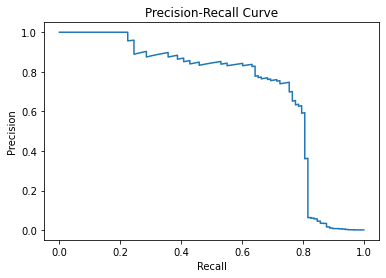

fbeta: 0.6443
AUC: 0.711
[[56850    13]
 [   35    63]]



In [37]:
#results = model_tester2(lr_clf, "lr", X_train=X_train_hour_amt_robust_log, y_train = y_train,
#                        X_val= X_val_hour_amt_robust_log, y_val=y_val)

============ rf_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9342    0.7245    0.8161        98

    accuracy                         0.9994     56961
   macro avg     0.9669    0.8622    0.9079     56961
weighted avg     0.9994    0.9994    0.9994     56961




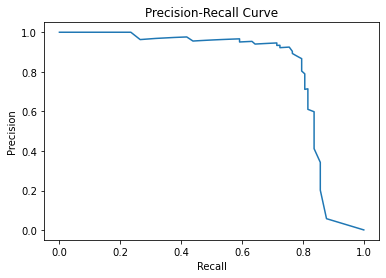

fbeta: 0.7261
AUC: 0.812
[[56858     5]
 [   27    71]]

============ brf_clf ============
              precision    recall  f1-score   support

           0     0.9997    0.9804    0.9900     56863
           1     0.0701    0.8571    0.1295        98

    accuracy                         0.9802     56961
   macro avg     0.5349    0.9188    0.5598     56961
weighted avg     0.9981    0.9802    0.9885     56961




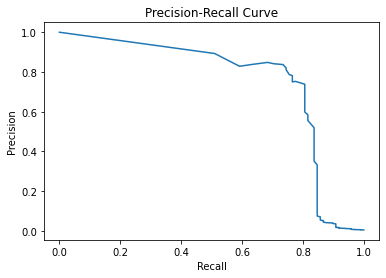

fbeta: 0.7713
AUC: 0.752
[[55748  1115]
 [   14    84]]

============ lr_clf ============


C:\Users\katar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56863
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56961
   macro avg     0.9142    0.8213    0.8619     56961
weighted avg     0.9991    0.9992    0.9991     56961




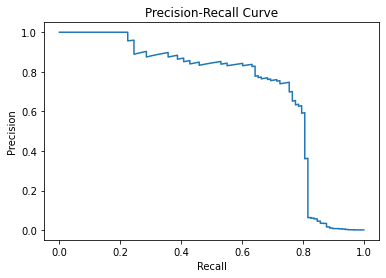

fbeta: 0.6443
AUC: 0.711
[[56850    13]
 [   35    63]]

============ svc_rbf_clf ============
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56863
           1     0.9545    0.6429    0.7683        98

    accuracy                         0.9993     56961
   macro avg     0.9770    0.8214    0.8840     56961
weighted avg     0.9993    0.9993    0.9993     56961




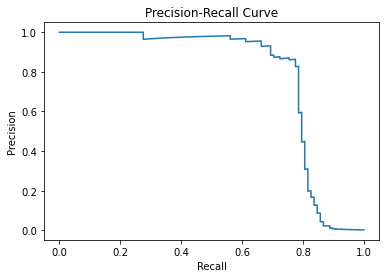

fbeta: 0.6449
AUC: 0.781
[[56860     3]
 [   35    63]]

============ svc_ploy_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9452    0.7041    0.8070        98

    accuracy                         0.9994     56961
   macro avg     0.9723    0.8520    0.9034     56961
weighted avg     0.9994    0.9994    0.9994     56961




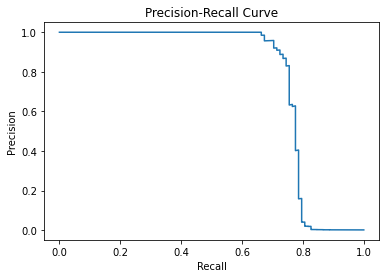

fbeta: 0.7059
AUC: 0.768
[[56859     4]
 [   29    69]]

============ knn_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.8947    0.6939    0.7816        98

    accuracy                         0.9993     56961
   macro avg     0.9471    0.8469    0.8906     56961
weighted avg     0.9993    0.9993    0.9993     56961




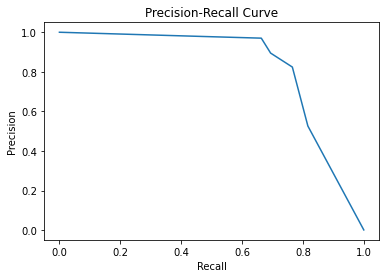

fbeta: 0.6954
AUC: 0.826
[[56855     8]
 [   30    68]]

============ gnb_clf ============
              precision    recall  f1-score   support

           0     0.9997    0.9589    0.9789     56863
           1     0.0327    0.8061    0.0629        98

    accuracy                         0.9587     56961
   macro avg     0.5162    0.8825    0.5209     56961
weighted avg     0.9980    0.9587    0.9773     56961




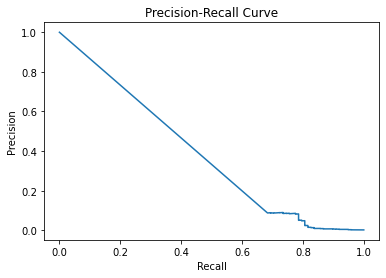

fbeta: 0.6532
AUC: 0.383
[[54527  2336]
 [   19    79]]

============ ada_clf ============
              precision    recall  f1-score   support

           0     0.9994    0.9997    0.9995     56863
           1     0.7750    0.6327    0.6966        98

    accuracy                         0.9991     56961
   macro avg     0.8872    0.8162    0.8481     56961
weighted avg     0.9990    0.9991    0.9990     56961




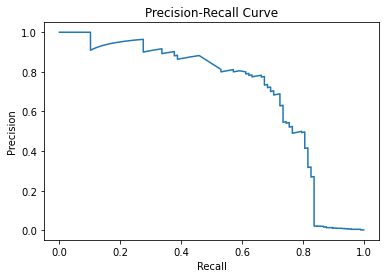

fbeta: 0.6338
AUC: 0.695
[[56845    18]
 [   36    62]]

============ qda_clf ============


C:\Users\katar\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

           0     0.9997    0.9373    0.9675     56863
           1     0.0222    0.8265    0.0432        98

    accuracy                         0.9371     56961
   macro avg     0.5109    0.8819    0.5054     56961
weighted avg     0.9980    0.9371    0.9659     56961




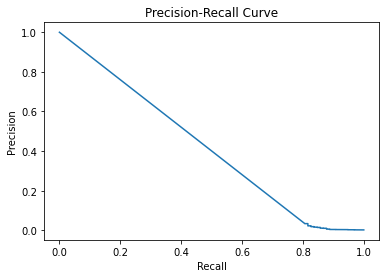

fbeta: 0.6083
AUC: 0.418
[[53296  3567]
 [   17    81]]

============ mlp_clf ============
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9467    0.7245    0.8208        98

    accuracy                         0.9995     56961
   macro avg     0.9731    0.8622    0.9103     56961
weighted avg     0.9994    0.9995    0.9994     56961




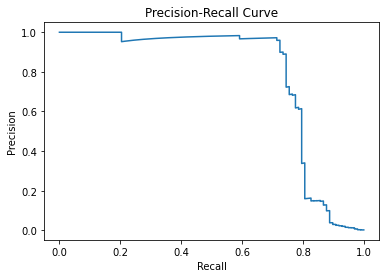

fbeta: 0.7262
AUC: 0.779
[[56859     4]
 [   27    71]]

============ xgb_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56863
           1     0.9375    0.7653    0.8427        98

    accuracy                         0.9995     56961
   macro avg     0.9685    0.8826    0.9212     56961
weighted avg     0.9995    0.9995    0.9995     56961




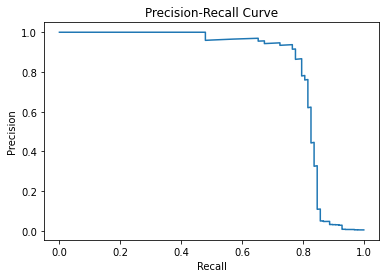

fbeta: 0.7667
AUC: 0.814
[[56858     5]
 [   23    75]]

============ xgbrf_clf ============
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8750    0.7857    0.8280        98

    accuracy                         0.9994     56961
   macro avg     0.9373    0.8928    0.9138     56961
weighted avg     0.9994    0.9994    0.9994     56961




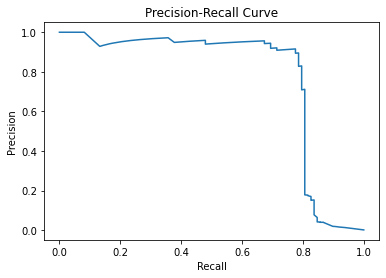

fbeta: 0.7865
AUC: 0.774
[[56852    11]
 [   21    77]]



In [25]:
eval_dict_new = dict()

for i, m in enumerate(models):
    eval_dict_new[model_names[i]] = model_tester2(m, model_names[i], X_train=X_train_hour_amt_robust_log, y_train=y_train,\
                                                       X_val=X_train_hour_amt_robust_log, y_val=y_val) 

In [26]:
eval_df_new = pd.DataFrame(data=eval_dict_new.values(), index=eval_dict_new.keys(),\
                       columns=['fbeta','bal_acc_score','precisions', 'recalls', 'auc_score', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [27]:
eval_df_new

,fbeta,bal_acc_score,precisions,recalls,auc_score,false_positives,false_negatives,train_time,test_time
rf_clf,0.726104,0.862201,0.058424,0.877551,0.811931,5,27,96.623500,0.498947
brf_clf,0.771343,0.918767,0.004737,0.989796,0.752443,1115,14,3.827660,0.446175
lr_clf,0.644289,0.821314,0.001753,0.989796,0.711401,13,35,2.295788,0.028476
svc_rbf_clf,0.644942,0.821402,0.001787,0.989796,0.781183,3,35,922.708860,14.374765
svc_ploy_clf,0.705864,0.852006,0.001713,0.989796,0.767530,4,29,152.210766,1.030225
knn_clf,0.695423,0.846868,0.526316,0.816327,0.826194,8,30,0.039499,179.984605
gnb_clf,0.653213,0.882521,0.002198,0.989796,0.383173,2336,19,3.347870,0.896062
ada_clf,0.633806,0.816168,0.002320,0.989796,0.694890,18,36,42.378641,0.605949
qda_clf,0.608343,0.881900,0.001945,0.989796,0.418431,3567,17,0.608992,0.075287
mlp_clf,0.726177,0.862210,0.002249,0.989796,0.779110,4,27,47.583128,0.091020


# ###########################################################
# _____    PLAYGROUND  -> a big mess starts here  
# ###########################################################

In [ ]:
class_weight = {
    0 : 10,
    1 : 1
}
rf_clf2 = RandomForestClassifier(class_weight=class_weight)
rf_clf2.fit(X_train_hour_amt_robust_log, y_train)

### Class weighting 0:10 - 1:1

In [ ]:
y_pr_cw = rf_clf2.predict(X_val_hour_amt_robust_log)

In [ ]:
print(metrics.classification_report(y_val, y_pr_cw, digits=4))

In [ ]:
print(confusion_matrix(y_val, y_pr_cw))

In [ ]:
fbeta_score(y_val, y_pr_cw, average='binary', beta=10, pos_label=1)

### No Class weight

In [ ]:
y_pr = rf_clf2.predict(X_val_hour_amt_robust_log)

In [ ]:
print(metrics.classification_report(y_val, y_pr, digits=4))

In [ ]:
print(confusion_matrix(y_val, y_pr))

In [ ]:
fbeta_score(y_val, y_pr, average='binary', beta=10, pos_label=1)

#  makro  avg f1 score
Checking how the models behave with the $macro avg f1 score$

In [ ]:
def model_tester_macrof1(clf, clf_name):
    print(f'============ {clf_name} ============')
    
       
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    try:
        feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': clf.feature_importances_})
        print(feature_importances.sort_values('importance', ascending=False, inplace=True))
    except Exception as e: 
        print(e)
        print(f'The {clf_name} model does not have a feature importance parameter')
        
    try:
        coefs = pd.DataFrame({'feature': X_train.columns, 'coef': clf.coef_})
        print(coefs.sort_values('coef', ascending=False, inplace=True))
    except Exception as e: 
        print(e)
        print(f'The {clf_name} model does not have a coef parameter')
    
    start_time = time.time()
    y_pred = clf.predict(X_val)
    test_time = time.time() - start_time
    
    print(metrics.classification_report(y_val, y_pred, digits=4), end='\n\n===============================================\n')
    bal_acc_score = balanced_accuracy_score(y_val, y_pred)
#     print(bal_acc_score, end='\n\n===============================================\n')
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    y_prob = clf.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    plot_roc_curve(fpr,tpr)
    plt.show()
    rocauc_score = roc_auc_score(y_val, y_prob)
    print(f'ROC AUC score: {rocauc_score}', end='\n\n===============================================\n')
    conf_mtr = confusion_matrix(y_val, y_pred)
    print(conf_mtr, end='\n\n===============================================\n')
    return [bal_acc_score,precisions, recalls, f1, macro_f1, conf_mtr[0,1], conf_mtr[1,0], train_time, test_time]

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')
scaler = MinMaxScaler()

raw_train_log['Amount_log'] = np.log1p(raw_train['Amount'])
clean_train = DataCleaner(hour=True,feature_to_drop=['Amount'], labels=True, imputer=imputer, scaler=scaler)

In [ ]:
X_train, y_train = clean_train.fit_transform(raw_train)
raw_val['Amount_log'] = np.log1p(raw_val['Amount'])
X_val, y_val = clean_train.transform(raw_val)

In [ ]:
model_names = ['rf_clf', 'brf_clf', 'lr_clf', 'svc_rbf_clf', 'svc_ploy_clf', 'knn_clf', 'gnb_clf', 'ada_clf',\
               'qda_clf', 'mlp_clf', 'xgb_clf', 'xgbrf_clf']
models = [rf_clf, brf_clf, lr_clf, svc_rbf_clf, svc_ploy_clf, knn_clf, gnb_clf, ada_clf, qda_clf, mlp_clf, xgb_clf, xgbrf_clf]

In [ ]:
eval_macro_dict = dict()

for i, m in enumerate(models):
    eval_macro_dict[model_names[i]] = model_tester_macrof1(m, model_names[i])

In [ ]:
eval_macro_df = pd.DataFrame(data=eval_macro_dict.values(), index=eval_macro_dict.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'macro_f1' 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [ ]:
eval_macro_df

### For $Grid_search$:

from sklearn.metrics import make_scorer, f1_score
macro_f1_scorer = make_scorer(f1_score, average='macro')

param_grid = {'max_depth': [1, 5, 10]}
clf = DecisionTreeClassifier()

grid_search = GridSearchCV(clf, param_grid, scoring=macro_f1_scorer)
grid_search.fit(X_train, y_train)


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

In [ ]:
eval_macro_dict.values()

# Feature selection
- Random Forest feature importance
- Logistic Regression with Lasso loss function
- Mutual information
- Forward selection
- Backward selection
- Best subset selection

### Mutual information

Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

In [ ]:
from sklearn.feature_selection import mutual_info_regression

In [ ]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.columns:
        mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=0)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
mi_scores = make_mi_scores(X=X_train, y=y_train)

In [ ]:
plot_mi_scores(mi_scores)

### Forward / Backward selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 

##### Forward

In [ ]:
feat_select_model = RandomForestClassifier()
sfs_fwd = SequentialFeatureSelector(feat_select_model, n_features_to_select='auto', direction='forward',\
                                     scoring='f1', cv=3, n_jobs=-1) # ‘recall’, ‘roc_auc’
sfs_fwd.fit(X_train, y_train)

In [ ]:
sfs_fwd.n_features_to_select_

In [ ]:
feature_mask_fwd = sfs_fwd.support_

result_list_fwd = [X_train.columns[i] for i in range(len(X_train.columns)) if feature_mask_fwd[i]]
print(result_list_fwd)

tol=0.02 → ['V10', 'V12', 'V14', 'Amount']

##### Backward

In [ ]:
sfs_bwd = SequentialFeatureSelector(feat_select_model, n_features_to_select='auto', direction='backward',\
                                     scoring='f1', cv=3, n_jobs=-1) # ‘recall’, ‘roc_auc’
sfs_bwd.fit(X_train, y_train)

In [ ]:
sfs_bwd.n_features_to_select_

In [ ]:
feature_mask_bwd = sfs_bwd.support_

result_list_bwd = [X_train.columns[i] for i in range(len(X_train.columns)) if feature_mask_bwd[i]]
print(result_list_bwd)

### Best subset selection

In [ ]:
from itertools import combinations
from sklearn.model_selection import cross_val_score

def best_subset(estimator, X, y, max_size=8, cv=5):
    '''Calculates the best model of up to max_size features of X.
   estimator must have a fit and score functions.
   X must be a DataFrame.'''

    n_features = X.shape[1]
    subsets = (combinations(range(n_features), k + 1) 
               for k in range(min(n_features, max_size)))

    best_size_subset = []
    for subsets_k in subsets:  # for each list of subsets of the same size
        best_score = -np.inf
        best_subset = None
        for subset in subsets_k: # for each subset
            estimator.fit(X.iloc[:, list(subset)], y)
            # get the subset with the best score among subsets of the same size
            score = estimator.score(X.iloc[:, list(subset)], y)
            if score > best_score:
                best_score, best_subset = score, subset
        # to compare subsets of different sizes we must use CV
        # first store the best subset of each size
        best_size_subset.append(best_subset)

    # compare best subsets of each size
    best_score = -np.inf
    best_subset = None
    list_scores = []
    for subset in best_size_subset:
        score = cross_val_score(estimator, X.iloc[:, list(subset)], y, cv=cv).mean()
        list_scores.append(score)
        if score > best_score:
            best_score, best_subset = score, subset

    return best_subset, best_score, best_size_subset, list_scores

In [ ]:
b_subset, b_score, b_size, b_list_scores = best_subset(feat_select_model, raw_train[:10], y_train[:10], max_size=20, cv=3)

In [ ]:
print(f'Best subset: {b_subset}', end='\n\n')
print(f'Best subset: {b_score}', end='\n\n')
print(f'Best subset: {b_size}', end='\n\n')
print(f'Best subset: {b_list_scores}', end='\n\n')

# Models

In [ ]:
from IPython.display import display
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score

from sklearn.ensemble import RandomForestClassifier #proba #featimp
from imblearn.ensemble import BalancedRandomForestClassifier #proba #featimp
from sklearn.linear_model import LogisticRegression #proba #coef
from sklearn.svm import SVC #kernel #proba #coef 
from sklearn.neighbors import KNeighborsClassifier #proba
from sklearn.naive_bayes import GaussianNB #proba
from sklearn.ensemble import AdaBoostClassifier #proba #featimp
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis #proba
from sklearn.neural_network import MLPClassifier #coef #proba
import xgboost as xgb #featimp #coef #proba

In [ ]:
rf_clf = RandomForestClassifier() #proba #featimp
brf_clf = BalancedRandomForestClassifier() #proba #featimp
lr_clf = LogisticRegression() #proba #coef
svc_rbf_clf = SVC(kernel='rbf', probability=True) #kernel #proba #coef 
svc_ploy_clf = SVC(kernel='poly', probability=True)
knn_clf = KNeighborsClassifier() #proba
gnb_clf = GaussianNB() #proba
ada_clf = AdaBoostClassifier() #proba #featimp
qda_clf = QuadraticDiscriminantAnalysis() #proba
mlp_clf = MLPClassifier() #coef #proba
xgb_clf = xgb.XGBClassifier() #featimp #coef #proba
xgbrf_clf = xgb.XGBRFClassifier() #featimp #coef #proba

In [ ]:
def model_tester(clf, clf_name):
    print(f'============ {clf_name} ============')
    clf.fit(X_train, y_train)
    try:
        feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': clf.feature_importances_})
        print(feature_importances.sort_values('importance', ascending=False, inplace=True))
    except Exception as e: 
        print(e)
        print(f'The {clf_name} model does not have a feature importance parameter')
        
    try:
        coefs = pd.DataFrame({'feature': X_train.columns, 'coef': clf.coef_})
        print(coefs.sort_values('coef', ascending=False, inplace=True))
    except Exception as e: 
        print(e)
        print(f'The {clf_name} model does not have a coef parameter')
        
    y_pred = clf.predict(X_val)
    
    print(metrics.classification_report(y_val, y_pred, digits=4), end='\n\n===============================================\n')
    bal_acc_score = balanced_accuracy_score(y_val, y_pred)
#     print(bal_acc_score, end='\n\n===============================================\n')
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    y_prob = clf.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    plot_roc_curve(fpr,tpr)
    plt.show()
    rocauc_score = roc_auc_score(y_val, y_prob)
    print(f'ROC AUC score: {rocauc_score}', end='\n\n===============================================\n')
    conf_mtr = confusion_matrix(y_val, y_pred)
    print(conf_mtr, end='\n\n===============================================\n')
    return [bal_acc_score,precisions, recalls, f1, conf_mtr[0,1], conf_mtr[1,0]]

In [ ]:
model_names = ['rf_clf', 'brf_clf', 'lr_clf', 'svc_rbf_clf', 'svc_ploy_clf', 'knn_clf', 'gnb_clf', 'ada_clf',\
               'qda_clf', 'mlp_clf', 'xgb_clf', 'xgbrf_clf']
models = [rf_clf, brf_clf, lr_clf, svc_rbf_clf, svc_ploy_clf, knn_clf, gnb_clf, ada_clf, qda_clf, mlp_clf, xgb_clf, xgbrf_clf]

In [ ]:
eval_dict = dict()

for i, m in enumerate(models):
    eval_dict[model_names[i]] = model_tester(m, model_names[i])

In [ ]:
eval_df = pd.DataFrame(data=eval_dict.values(), index=eval_dict.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives'])

In [ ]:
eval_df

# ------------------POC----------------------------------------- 


In [ ]:
# Splitint training data for POC purposes (only about 2 mln instances)

raw_train.shape

In [ ]:
raw_train.head()

In [ ]:
drop_list = ['Class', 'hour']

X_train_poc = raw_train.drop(drop_list, axis=1)
X_train_poc

In [ ]:
print("X_train_poc set dimensions: ", X_train_poc.shape)
print("y_train set dimensions: ", y_train.shape)

# ------------------------ Training ---------------------

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train_poc, y_train)

In [ ]:
# to show floats with 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

feature_importances = pd.DataFrame({'feature': X_train_poc.columns, 'importance': clf.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)
print(feature_importances)

# ---------Testing and performance analysis---------

### Data preparation

In [ ]:
raw_test.head()

In [ ]:
raw_test.shape

In [ ]:
X_test_poc = raw_test.drop(columns = ['Class'], axis=1) #droppig the same columns as in case of training set
y_test_poc = raw_test['Class'] #getting labels

print(X_test_poc.columns)

### Predictions

In [ ]:
y_pred =clf.predict(X_test_poc)


### Performance analysis

In [ ]:
print(metrics.classification_report(y_test_poc, y_pred, digits=4))

In [ ]:
balanced_accuracy_score(y_test_poc, y_pred)

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test_poc, y_pred)

### ROC curve

**<code style="background:yellow;color:blue"> FROM THE BOOK </code>**

The roc_curve() function expects labels and scores, but instead of scores you can
give it class probabilities. Let’s use the positive class’s probability as the score:

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class 

In [ ]:
y_prob = clf.predict_proba(X_test_poc)[:,1]

In [ ]:
from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(y_test_poc, y_prob)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)

In [ ]:
plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_poc, y_prob)

In [ ]:
#metrics.ConfusionMatrixDisplay.from_predictions(y_test_poc, y_pred)
#plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_test_poc, y_pred)

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
  Not bad but still can be better. Especially if it goes to recall on Frauds. 

# -------------------- With hour instead of Time -------------------

In [ ]:
drop_list1 = ['Class', 'Time']
X_train_poc1 = train_t.drop(drop_list1, axis=1)
X_train_poc1.head()

In [ ]:
# one-hot-encoded dataset
X_train_poc1 = pd.get_dummies(X_train_poc1, columns = ['hour'], prefix='hour')
X_train_poc1.head(10)

In [ ]:
clf_s1 = RandomForestClassifier()
clf_s1.fit(X_train_poc1, y_train)

In [ ]:
# to show floats with 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

feature_importances = pd.DataFrame({'feature': X_train_poc1.columns, 'importance': clf_s1.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)
print(feature_importances)

In [ ]:
## Test dataset prepareation
raw_test['hour'] = ((((raw_test['Time']) // (60 * 60)) % 24) + 1) # I calculate floor to get hours. As a result I get values from 0 to 47. Next I calulate modulo 24 -> I got values from 0 to 23. Last step adding 1 to get values from 1 to 24.
raw_test['hour'] = raw_test['hour'].astype(int)
print(raw_test['hour'].min(), raw_test['hour'].max())

X_test_poc1 = raw_test.drop(drop_list1, axis=1)
y_test = raw_test['Class']

In [ ]:
# one-hot-encoded dataset
X_test_poc1 = pd.get_dummies(X_test_poc1, columns = ['hour'], prefix='hour')
X_test_poc1.head(10)

In [ ]:
y_pred1 =clf_s1.predict(X_test_poc1)

In [ ]:
print(metrics.classification_report(y_test, y_pred1, digits=4))

In [ ]:
balanced_accuracy_score(y_test, y_pred1)

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred1)

# ---------------- ROC curve--------------------------

In [ ]:
y_prob1 = clf_s1.predict_proba(X_test_poc1)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob1)

plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
roc_auc_score(y_test, y_prob1)

In [ ]:
confusion_matrix(y_test, y_pred1)

### Observation:

- it is not better.

NEXT STEPS:
- check the result after removing the 'time' column
- deside which feature shouls stay. Maybe it would be good to run lasso and compare the feature importance from RF and lasso. Based on that maybe it will be possible to deside which features are more important. 


# --------------- Balanced Random Forest --------------

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train_poc, y_train)

In [ ]:
y_pred = brf.predict(X_test_poc)
balanced_accuracy_score(y_test_poc, y_pred)

In [ ]:
print(metrics.classification_report(y_test_poc, y_pred, digits=4))

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test_poc, y_pred)

In [ ]:
y_prob = brf.predict_proba(X_test_poc)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_poc, y_prob)

plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
roc_auc_score(y_test_poc, y_prob)

In [ ]:
confusion_matrix(y_test_poc, y_pred)

# This model could be chosen in an ensemble because it is better at recall but very bad in precision

### -> just to check how the feature importance looks for this model

In [ ]:
# to show floats with 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

feature_importances = pd.DataFrame({'feature': X_train_poc.columns, 'importance': brf.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)
print(feature_importances)

## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr_clf = LogisticRegression(penalty='l1', solver='liblinear')
lr_clf.fit(X_train_poc1, y_train)

In [ ]:
y_pred_lr = lr_clf.predict(X_test_poc1)

In [ ]:
log_importance = dict(zip(list(X_test_poc1.columns), lr_clf.coef_.tolist()[0]))

In [ ]:
pd.DataFrame(index=log_importance.keys(), data=log_importance.values()).sort_values(0, ascending=False)

In [ ]:
print(metrics.classification_report(y_test_poc, y_pred_lr, digits=4))

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test_poc, y_pred_lr)

In [ ]:
y_prob_lr = lr_clf.predict_proba(X_test_poc)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_poc, y_prob_lr)

plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
roc_auc_score(y_test_poc, y_prob_lr)

In [ ]:
confusion_matrix(y_test_poc, y_pred_lr)

## XGBoost

In [ ]:
# pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
xgb_clf = xgb.XGBClassifier()

In [ ]:
xgb_clf.fit(raw_train, y_train)

In [ ]:
xgb_feat_imp = dict(zip(raw_train.columns, xgb_clf.feature_importances_))
pd.DataFrame(data=xgb_feat_imp.values(), index=xgb_feat_imp.keys()).sort_values(0, ascending=False)

In [ ]:
y_pred_xgb = xgb_clf.predict(X_test_poc)

In [ ]:
print(metrics.classification_report(y_test_poc, y_pred_xgb, digits=4))

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test_poc, y_pred_xgb)

In [ ]:
y_prob_xgb = xgb_clf.predict_proba(X_test_poc)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_poc, y_prob_xgb)

plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
roc_auc_score(y_test_poc, y_prob_xgb)

In [ ]:
confusion_matrix(y_test_poc, y_pred_xgb)

In [ ]:
# Model function

def model_tester(model, X_train, X_val, y, scaled=False, hour=False):
    """The datasets Amount values are not scaled, and the Time column is based on seconds.
    With scaled=True, we will scale the Amount column.
    With hour=True, we will use the hours instead of seconds.
    """
    if scaled==False:
        if hour==True:
            train_t = X_train
            train_t['hour'] = ((((train_t['Time']) // (60 * 60)) % 24) + 1) # I calculate floor to get hours. As a result I get values from 0 to 47. Next I calulate modulo 24 -> I got values from 0 to 23. Last step adding 1 to get values from 1 to 24.
            train_t['hour'] = train_t['hour'].astype(int)
            
            
            
            
model.fit()

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)

In [ ]:
knn.fit(X_train_poc, y_train)

In [ ]:
y_pred_knn = knn.predict(X_test_poc)

In [ ]:
print(metrics.classification_report(y_test_poc, y_pred_knn, digits=4))

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test_poc, y_pred_knn)

In [ ]:
y_prob_knn = knn.predict_proba(X_test_poc)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_poc, y_prob_knn)

plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
roc_auc_score(y_test_poc, y_prob_knn)

In [ ]:
confusion_matrix(y_test_poc, y_pred_knn)

## ------ PIPELINE with SAMPLER 

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()

clean_train = DataCleaner(hour=True, feature_to_drop=[], labels=True, imputer=imputer, scaler=scaler)

In [ ]:
X_train, y = clean_train.fit_transform(raw_train)

In [ ]:
X_train.columns

In [ ]:
X_val, y_val = clean_train.transform(raw_val)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
#import xgboost as xgb 

#xgb_clf = xgb.XGBClassifier()
clf = LogisticRegression(max_iter = 5000, solver='saga')
sampler = RandomOverSampler(random_state=0)
model = make_pipeline(sampler, clf).fit(X_train, y)

In [ ]:
y_pred = model.predict(X_val)

In [ ]:
print(metrics.classification_report(y_val, y_pred, digits=4))

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_val, y_pred)